In [2]:
from src.implementations import *

import numpy as np
import pandas as pd

import zipfile
import warnings

from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE, trustworthiness
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from transformers import AutoTokenizer, AutoModel
import torch
import umap

c:\Users\nithu\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
# Ignore benign warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

# <b><u> Data Loading </u></b> #

We load only the relevant columns since the dataset is already quite large (3 million rows).

In [73]:
zip_file_path = 'data/BindingDB_All_202409_tsv.zip'
file_path = 'data/BindingDB_All.tsv'

list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Institution', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('BindingDB_All.tsv') as file:
        data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])

data = pd.DataFrame(data)
data.head()

C:\Users\nithu\AppData\Local\Temp\ipykernel_101868\308637278.py:13: DtypeWarning:

Columns (8,9,10,11,12,13,15,23,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.



Ligand SMILES  \
0  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...   
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...   
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...   
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...   
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...   

                              Target Name  \
0  Dimer of Gag-Pol polyprotein [501-599]   
1  Dimer of Gag-Pol polyprotein [501-599]   
2  Dimer of Gag-Pol polyprotein [501-599]   
3  Dimer of Gag-Pol polyprotein [501-599]   
4  Dimer of Gag-Pol polyprotein [501-599]   

  Target Source Organism According to Curator or DataSource Ki (nM) IC50 (nM)  \
0                     Human immunodeficiency virus 1           0.24       NaN   
1                     Human immunodeficiency virus 1           0.25       NaN   
2                     Human immunodeficiency virus 1           0.41       NaN   
3                     Human immunodeficiency virus 1            0.8       NaN   
4                     Human immunodeficiency virus 1           0.99       NaN   

  Kd (nM) EC50 (nM) kon (M-1-s-1) koff (s-1)   pH  ...  \
0     NaN       NaN           NaN        NaN  5.5  ...   
1     NaN       NaN           NaN        NaN  5.5  ...   
2     NaN       NaN           NaN        NaN  5.5  ...   
3     NaN       NaN           NaN        NaN  5.5  ...   
4     NaN       NaN           NaN        NaN  5.5  ...   

  BindingDB Target Chain Sequence.3 BindingDB Target Chain Sequence.4  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

   BindingDB Target Chain Sequence.5 BindingDB Target Chain Sequence.6  \
0                                NaN                               NaN   
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   

  BindingDB Target Chain Sequence.7 BindingDB Target Chain Sequence.8  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4                               NaN                               NaN   

  BindingDB Target Chain Sequence.9 BindingDB Target Chain Sequence.10  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

  BindingDB Target Chain Sequence.11 BindingDB Target Chain Sequence.12  
0                                NaN                                NaN  
1                                NaN                                NaN  
2                                NaN                                NaN  
3                                NaN                                NaN  
4                                NaN                                NaN  

[5 rows x 26 columns]

# <b><u> Some Insight on Data </u></b> #

<b> The dataset is extensive and encompasses a wide range of organisms. Due to the computational limitations of our systems and the complexity of the data (e.g., SMILES strings and target chains), it is more practical to narrow our focus to a specific subset of organisms rather than processing the entire dataset. </b>

First, we check the number of proteins for each organism. Since we will be performing data cleaning, we will focus on organisms with high protein counts.

In [9]:
# Get the value counts in the organism column
col_name = 'Target Source Organism According to Curator or DataSource'
if col_name in data.columns:
    value_counts = data.groupby(col_name).size().sort_values(ascending=False)
print(value_counts[0:10])

Target Source Organism According to Curator or DataSource
Homo sapiens                      1541025
Rattus norvegicus                  109758
Mus musculus                        49854
Rattus                              33718
Human immunodeficiency virus 1      21780
Bos taurus                          17618
Electrophorus electricus             7921
Cavia porcellus                      7639
Cavia cutleri                        6540
Escherichia coli                     5651
dtype: int64


Studying complex organisms, such as mammals like Homo sapiens, is challenging due to their biological intricacy and the vast scope of diverse research areas (e.g., oncology, metabolism, genetic diseases). In contrast, virus research is primarily focused on neutralizing their virulence, making them more straightforward targets for analysis. This distinction guides our decision to focus on viruses as the target organisms for this study. Amongst the viruses, HIV-1, has the highest count. Hence we made a decision to focus on HIV. 

To justify it further, we compare the counts of different viruses and identify the institutions that studied them.

total number of virus associated protein: 42342


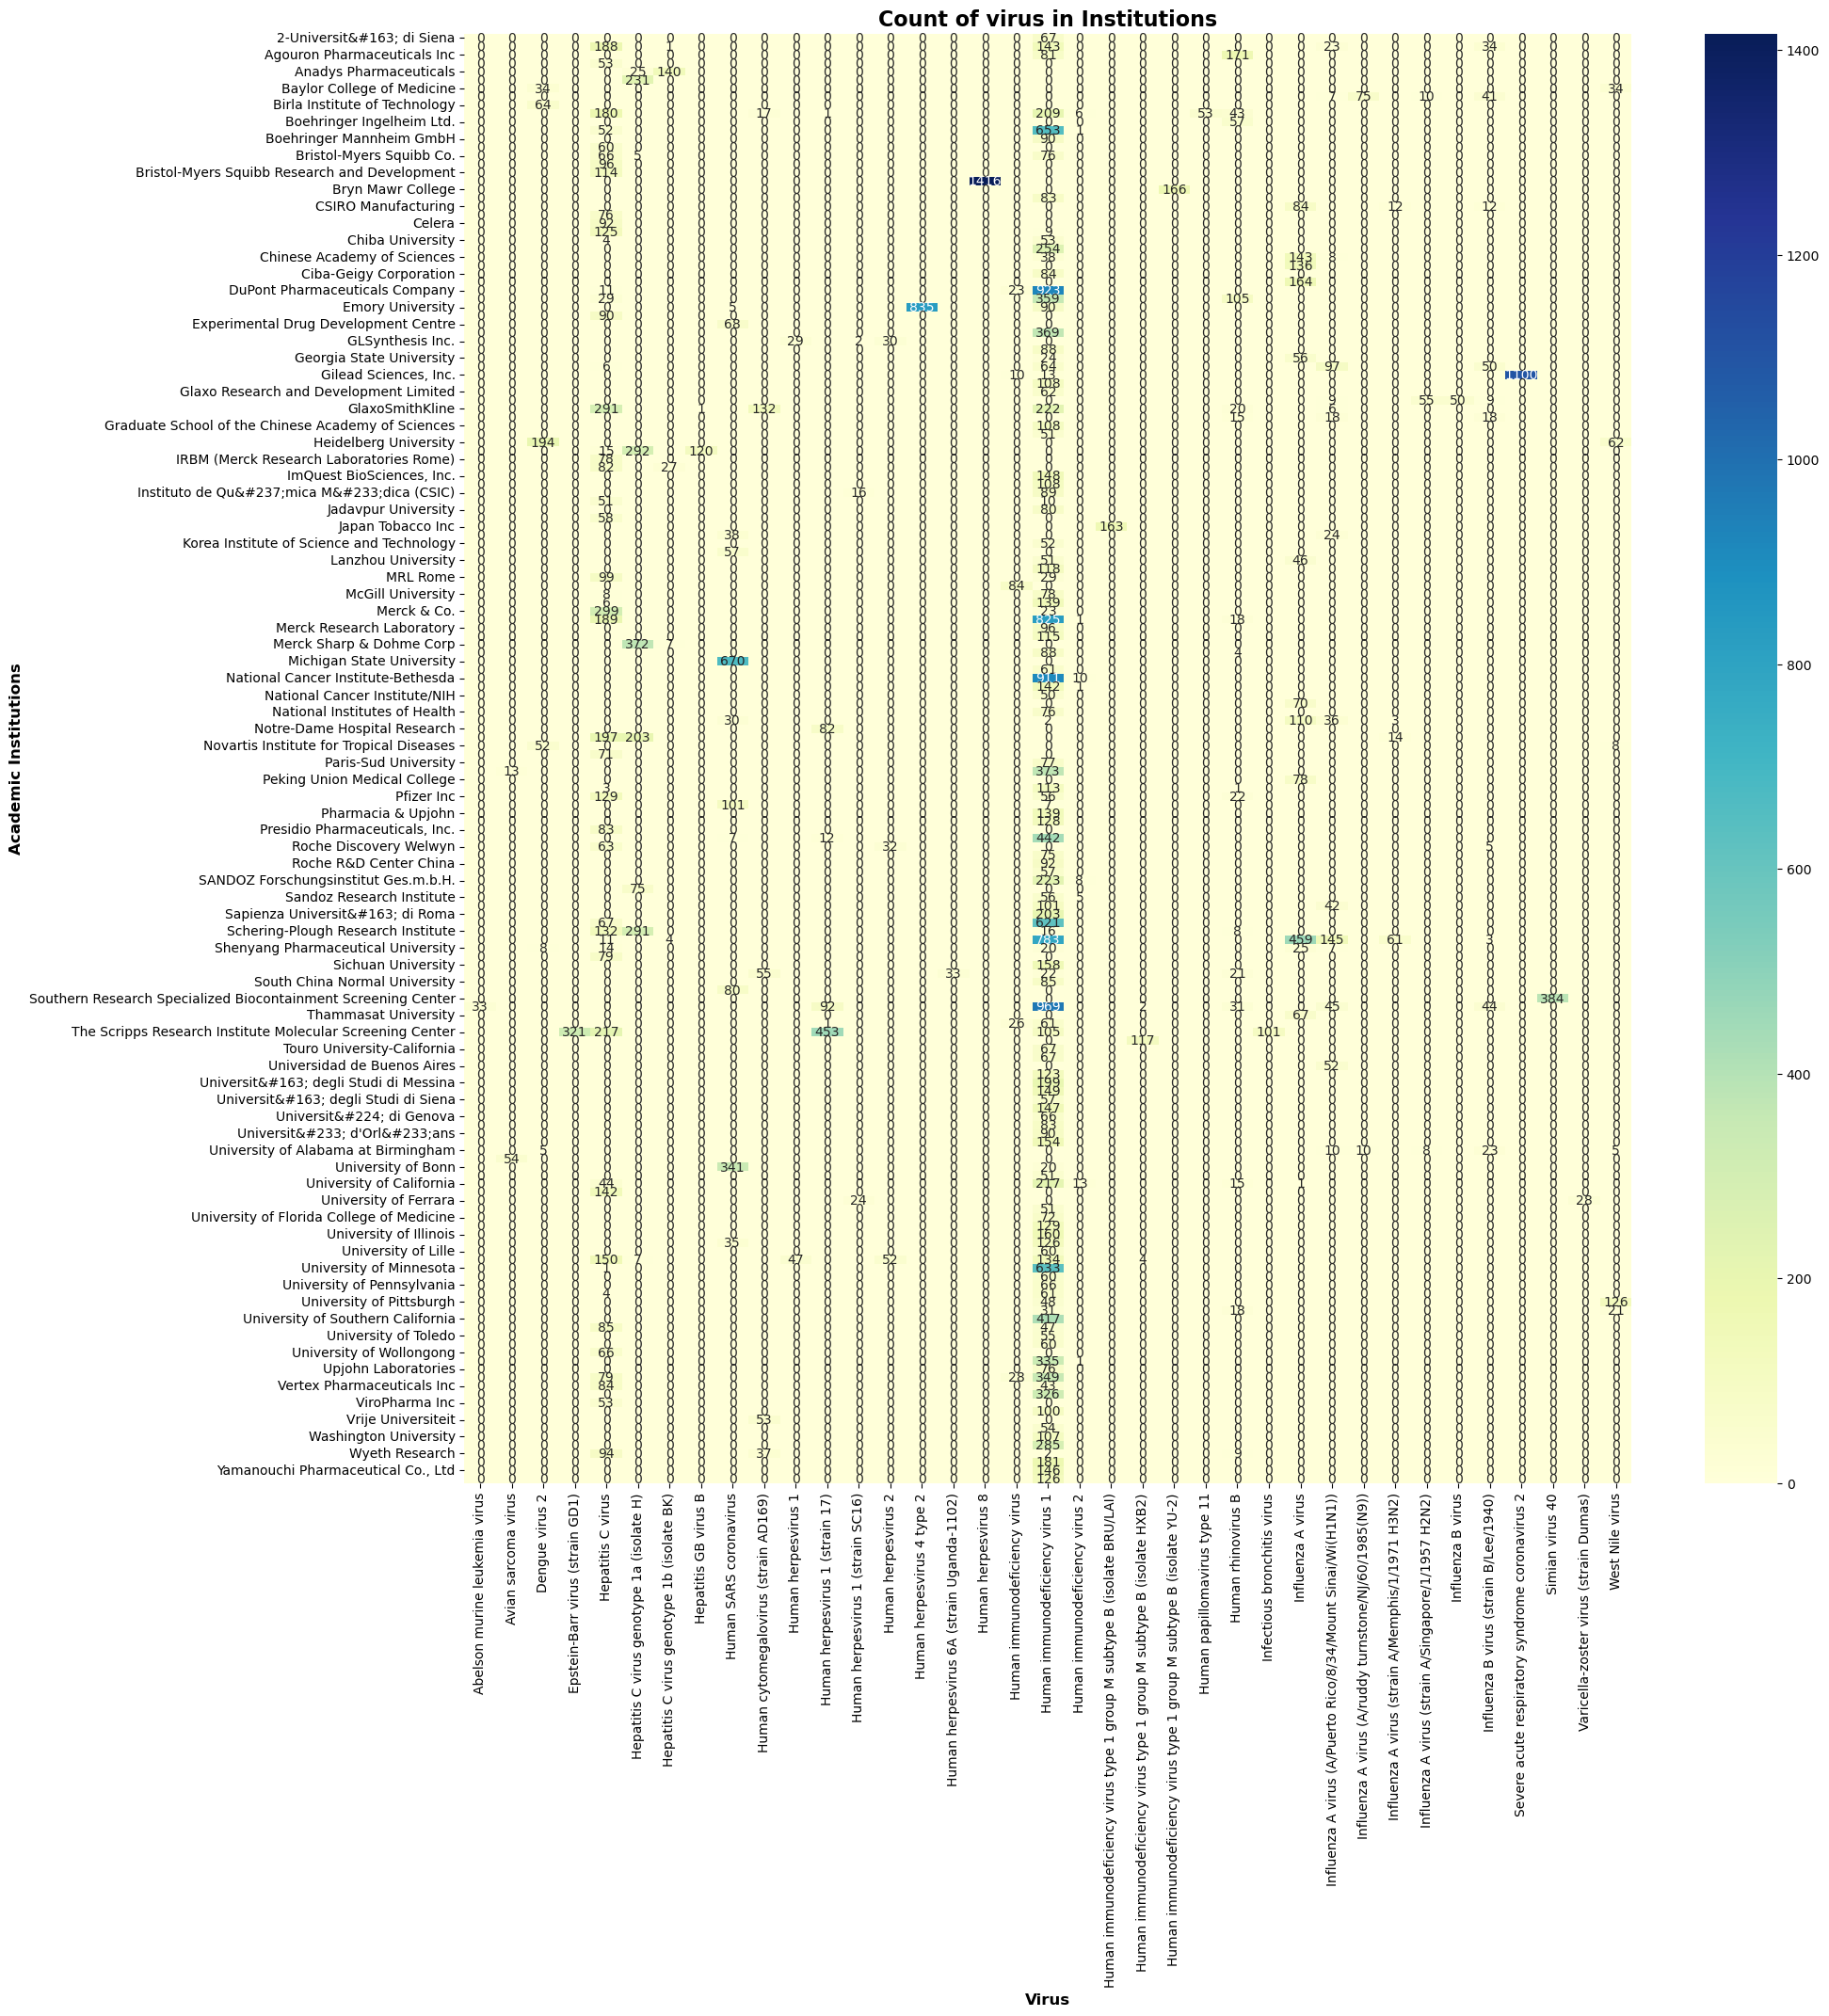

In [10]:
virus_data = data[data['Target Source Organism According to Curator or DataSource'].str.contains('virus', case=False, na=False)]

print(f'total number of virus associated protein: {virus_data["Target Source Organism According to Curator or DataSource"].value_counts().sum()}')

virus_counts = pd.crosstab(virus_data['Institution'], 
                           virus_data['Target Source Organism According to Curator or DataSource'])

virus_counts = virus_counts.loc[:, virus_counts.sum(axis=0) >= 50] 
virus_counts = virus_counts[virus_counts.sum(axis=1) >= 50]

plt.figure(figsize=(20, 20))
sns.heatmap(virus_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Count of virus in Institutions', fontweight=800,fontsize=16)
plt.xlabel('Virus',fontweight=800,fontsize=12)
plt.ylabel('Academic Institutions', fontweight=800,fontsize=12)
plt.show()

Among all viruses, HIV-1 is the only one with sufficient Ki data and is extensively studied by numerous labs. In contrast, the available Kd data is too sparse to be useful.

In [11]:
non_nan_ki = virus_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (all viruses): ', non_nan_ki)

non_nan_kd = virus_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (all viruses): ', non_nan_kd)

Numbers of data containing Ki information (all viruses):  6415
Numbers of data containing Kd information (all viruses):  406


In [74]:
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)

non_nan_ki = hiv_data['Ki (nM)'].count()
print('Numbers of data containing Ki information (Hiv1): ', non_nan_ki)

non_nan_kd = hiv_data['Kd (nM)'].count()
print('Numbers of data containing Kd information (Hiv1): ', non_nan_kd)

Numbers of data containing Ki information (Hiv1):  4350
Numbers of data containing Kd information (Hiv1):  237


# <b><u> Focusing on HIV-1 </u></b> #

<b> Here we check if HIV-1 data is sufficient and viable to train a machine learning model. </b>

Some data rows contain Ki values like '<100' or '>30000', which are difficult to interpret. Therefore, we choose to drop these rows.

In [75]:
# Choosing the metric which is the most present
metric = 'Ki (nM)'

# Filter for Hiv1
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)
print(f'prior size: {hiv_data.shape[0]}')

mask_invalid_values = hiv_data[metric].str.contains('<',case=False,na=False) | hiv_data[metric].str.contains('>',case=False,na=False) | hiv_data[metric].isna()
print(f'final size: {hiv_data.shape[0] - mask_invalid_values.sum()}')
hiv_data = hiv_data[~mask_invalid_values]

prior size: 21780
final size: 4171


Let's check the distribution of Ki. Ideally, it should be diverse to train a machine learning model.

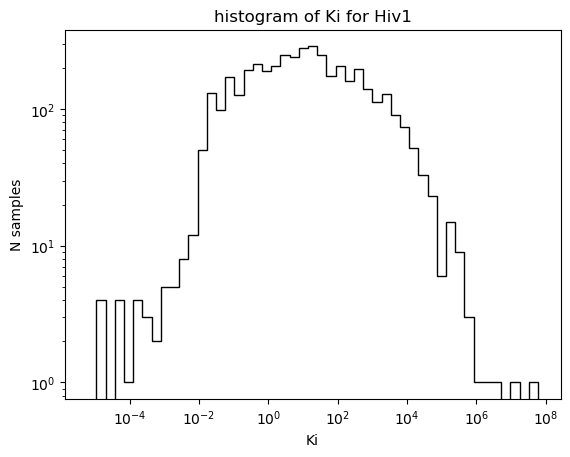

In [14]:
metric_numeric = pd.to_numeric(hiv_data[metric], errors='coerce').dropna()
bins = np.logspace(np.log10(metric_numeric.min()), np.log10(metric_numeric.max()), 50)
plt.hist(metric_numeric, bins=bins, edgecolor="black", histtype="step", log=True)

plt.xscale('log')
plt.title('histogram of Ki for Hiv1')
plt.xlabel('Ki')
plt.ylabel('N samples')
plt.show()

The data contains duplicate ligands and targets. For the machine learning model, it would be best to start by training on a single abundant unique target to refine the model and then gradually incorporate the complexity of multitarget learning. Additionally, it is important to ensure diversity among the proteins, as we would like the model to generalize better.

Number of Ligand compounds in HIV1:  5638


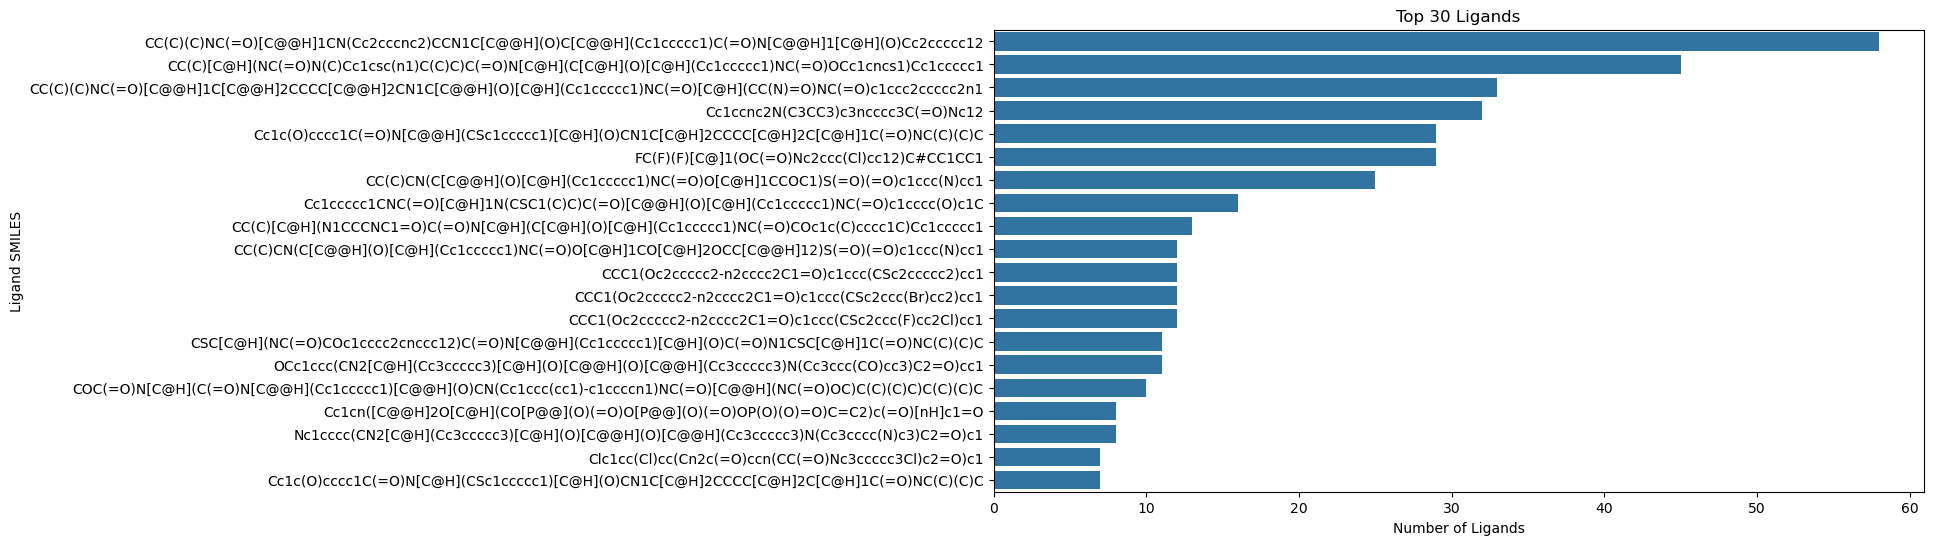

In [15]:
target_counts = hiv_data.groupby('Ligand SMILES').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of Ligand compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Ligand SMILES', data=target_counts.head(20))
plt.title('Top 30 Ligands')
plt.xlabel('Number of Ligands')
plt.ylabel('Ligand SMILES')
plt.show()

Number of targets of the compounds in HIV1:  126


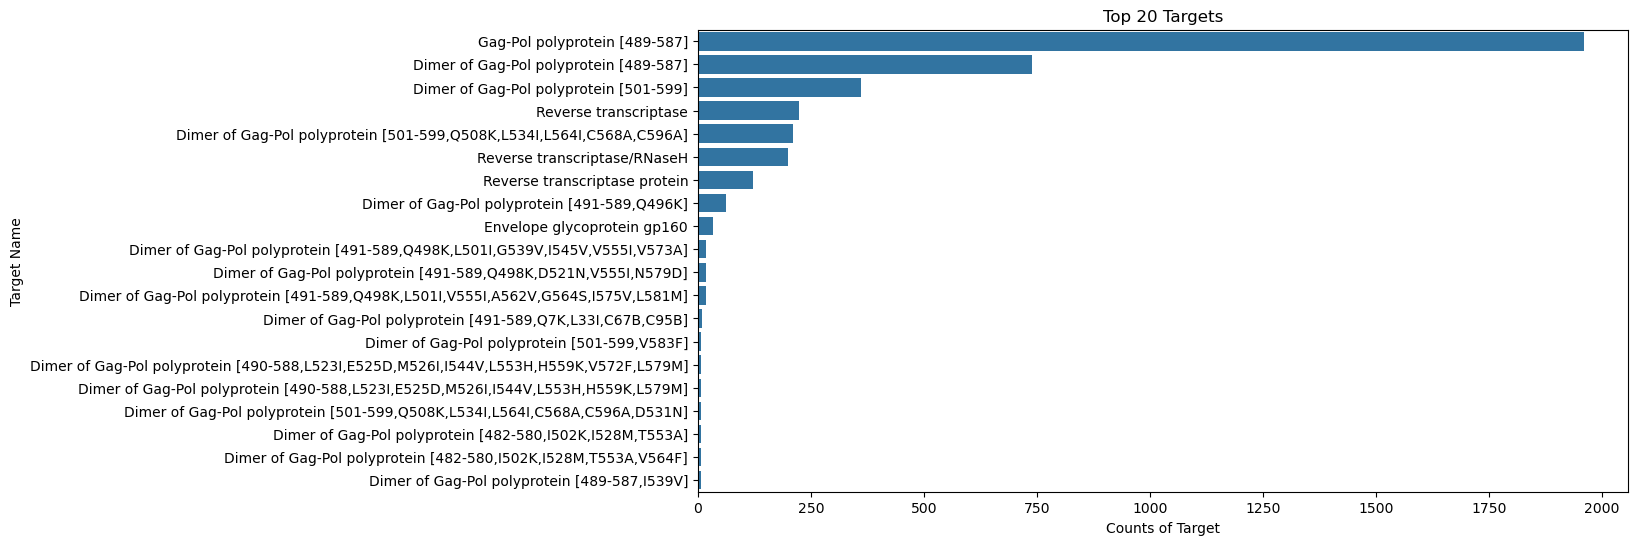

In [16]:
# Check the targets for Hiv1
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20))
plt.title('Top 20 Targets')
plt.xlabel('Counts of Target')
plt.ylabel('Target Name')
plt.show()

Some targets consist of multiple chains, which we need to account for in the machine learning model. We could either concatenate the chains of such targets and treat them as a single entity or handle them as separate parameters. This has not yet been decided.

In [17]:
col_name = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
seq_col = 'BindingDB Target Chain Sequence'

if col_name in hiv_data.columns and seq_col in hiv_data.columns:
    unique_data = hiv_data.drop_duplicates(subset=[seq_col])
    count_Nchain = unique_data[col_name].value_counts()

count_Nchain

Number of Protein Chains in Target (>1 implies a multichain complex)
1    56
2     7
Name: count, dtype: int64

# <u><b>CLUSTERING</b></u>

<b> To train a machine learning model, we must provide it with numerical data. For ligands, the only relevant information available is SMILES strings. Additionally, the data needs to be suitable for training, with data points that are differentiable.

To obtain continuous data, we first embed the SMILES using one of two algorithms: BERT embedding (using ChemBERTa) or Morgan Fingerprint.

Next, for visualisation purposes and due to computational constraints, we reduce the dimensionality of the data to three using two algorithms: t-SNE or UMAP. Both algorithms have their advantages and disadvantages. (We initially tried out PCA but we were not getting any good results, hence we decided to try better suited algorithms, hence t-SNE and UMAP.)

To draw final conclusions, we perform k-means clustering on the four combinations (BERT+t-SNE, BERT+UMAP, Morgan Fingerprint+t-SNE, Morgan Fingerprint+UMAP). We visually and numerically evaluate the best clusters with scores (silhouette score, Kullback-Leibler divergence for t-SNE, trustworthiness score for UMAP and normalized entropy). Clear, well-separated and balanced clusters are preferred. </b>

## <b>Clustering with Morgan Fingerprints: </b> ##

Advantages:

- The embedding is based on the environment of each atom (the surrounding atoms), providing a direct connection to the molecular structure.
- Produces a fixed vector size for each molecule, which can aid in clustering.
- Well-established and widely tested.

Inconveniences:

- Captures either local or global structures, depending on the radius (a hyperparameter) of the atom environments.
- Better suited for classification tasks; however, dimensionality reduction can mitigate this limitation.
- Highly sensitive to the radius parameter. If the radius is too large or too small, it can result in either overly sparse clusters or clusters that are difficult to differentiate.

More info on Morgan Fingerprints can be found in the implementation of [RDKit](https://github.com/rdkit/rdkit), and our implementations.py file.

Note: for dimension reduction of Morgan Fingerprints, we will use jaccard metric as it is suited for binary vectors

In [76]:
smiles_list = hiv_data['Ligand SMILES'].unique().tolist()

### Using TSNE: Generate Fingerprints + Compute and Plot Scores ###

Here and for each of subsequent combinations, we will evaluate the best number of clusters for k-means based on elbow method and silhouette score.

Radius = 2
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 3
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 4
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50
Radius = 5
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


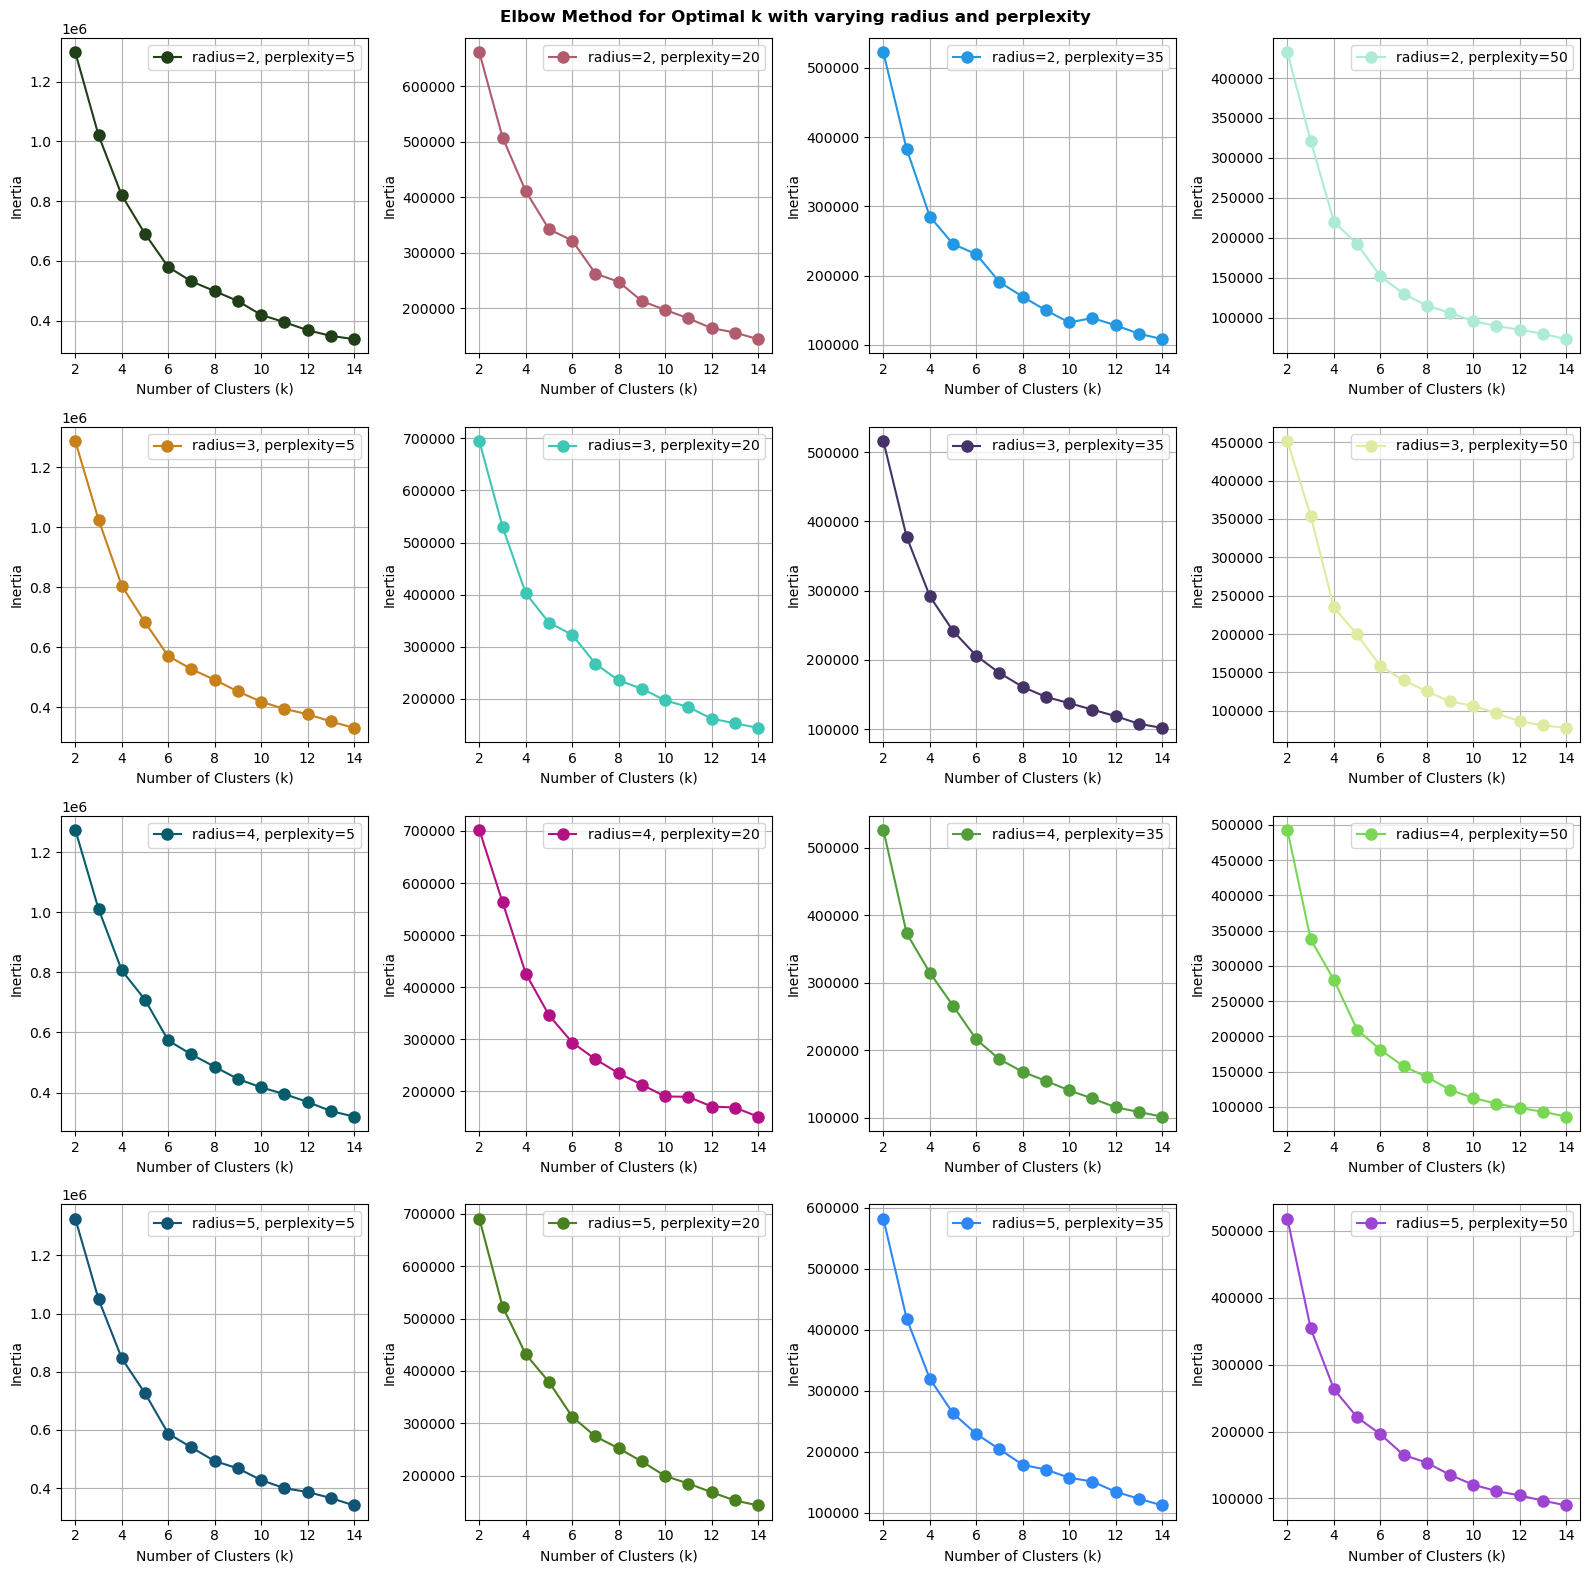

In [19]:
# For t-SNE, an important parameter to tune is perplexity (effective number of neighbors).
# We also tune the radius for Morgan Fingerprints

radiuses = [2,3,4,5]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsn_results, KLs, s_scores = plot_elbow_curve(
    method='tsne',
    original_data=smiles_list,
    param1_list=radiuses,
    param2_list=perplexities,
    Ks=Ks,
    param1_name='radius',
    param2_name='perplexity',
    metric='jaccard',
    generate_MF=True
)

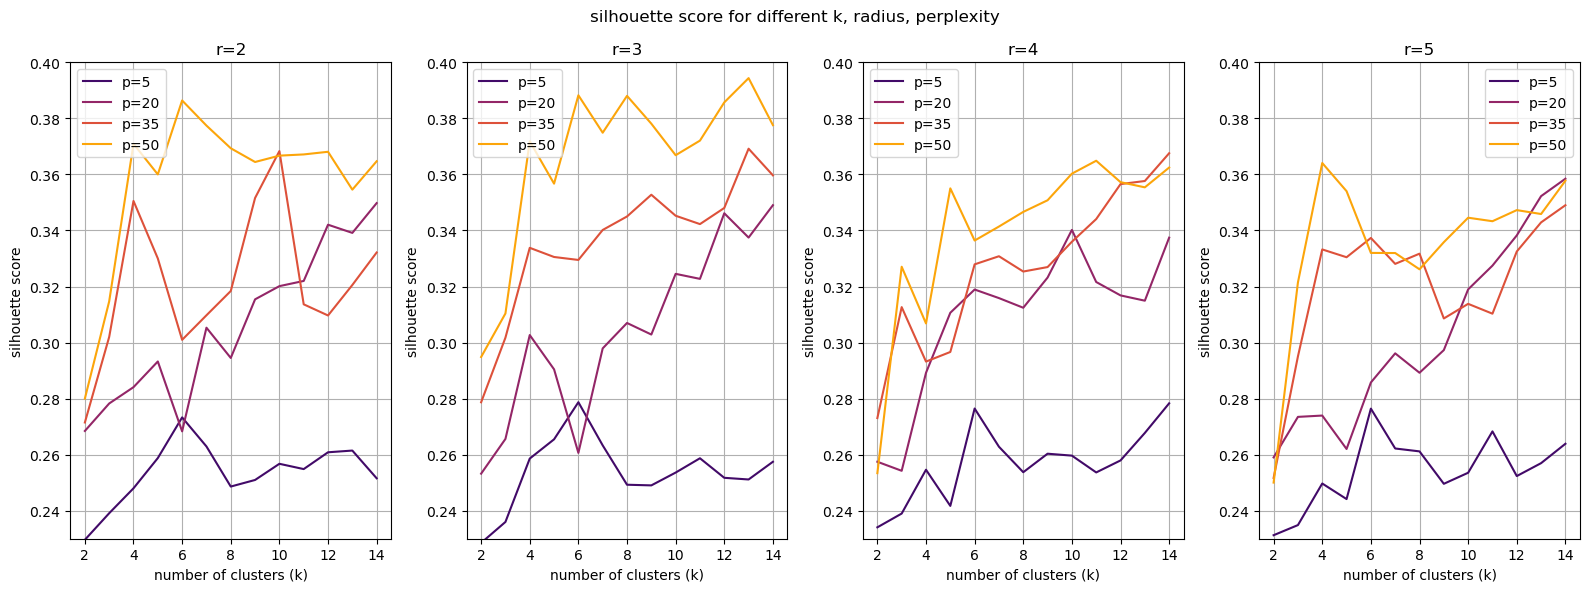

In [20]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.4),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

### Choosing best clusters from plots + Observing according distributions ###

Here, we first choose the best k for each combination manually and then plot the distribution of the clusters. The normalized entropy score is used to evaluate good distributions across the clusters (see implementations to have more info on this metric).

In [21]:
# Choose best k for each radius and perplexity based on the graphs (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,12,10,6],
           [6,12,9,6],
           [6,10,12,11],
           [6,12,6,4]]

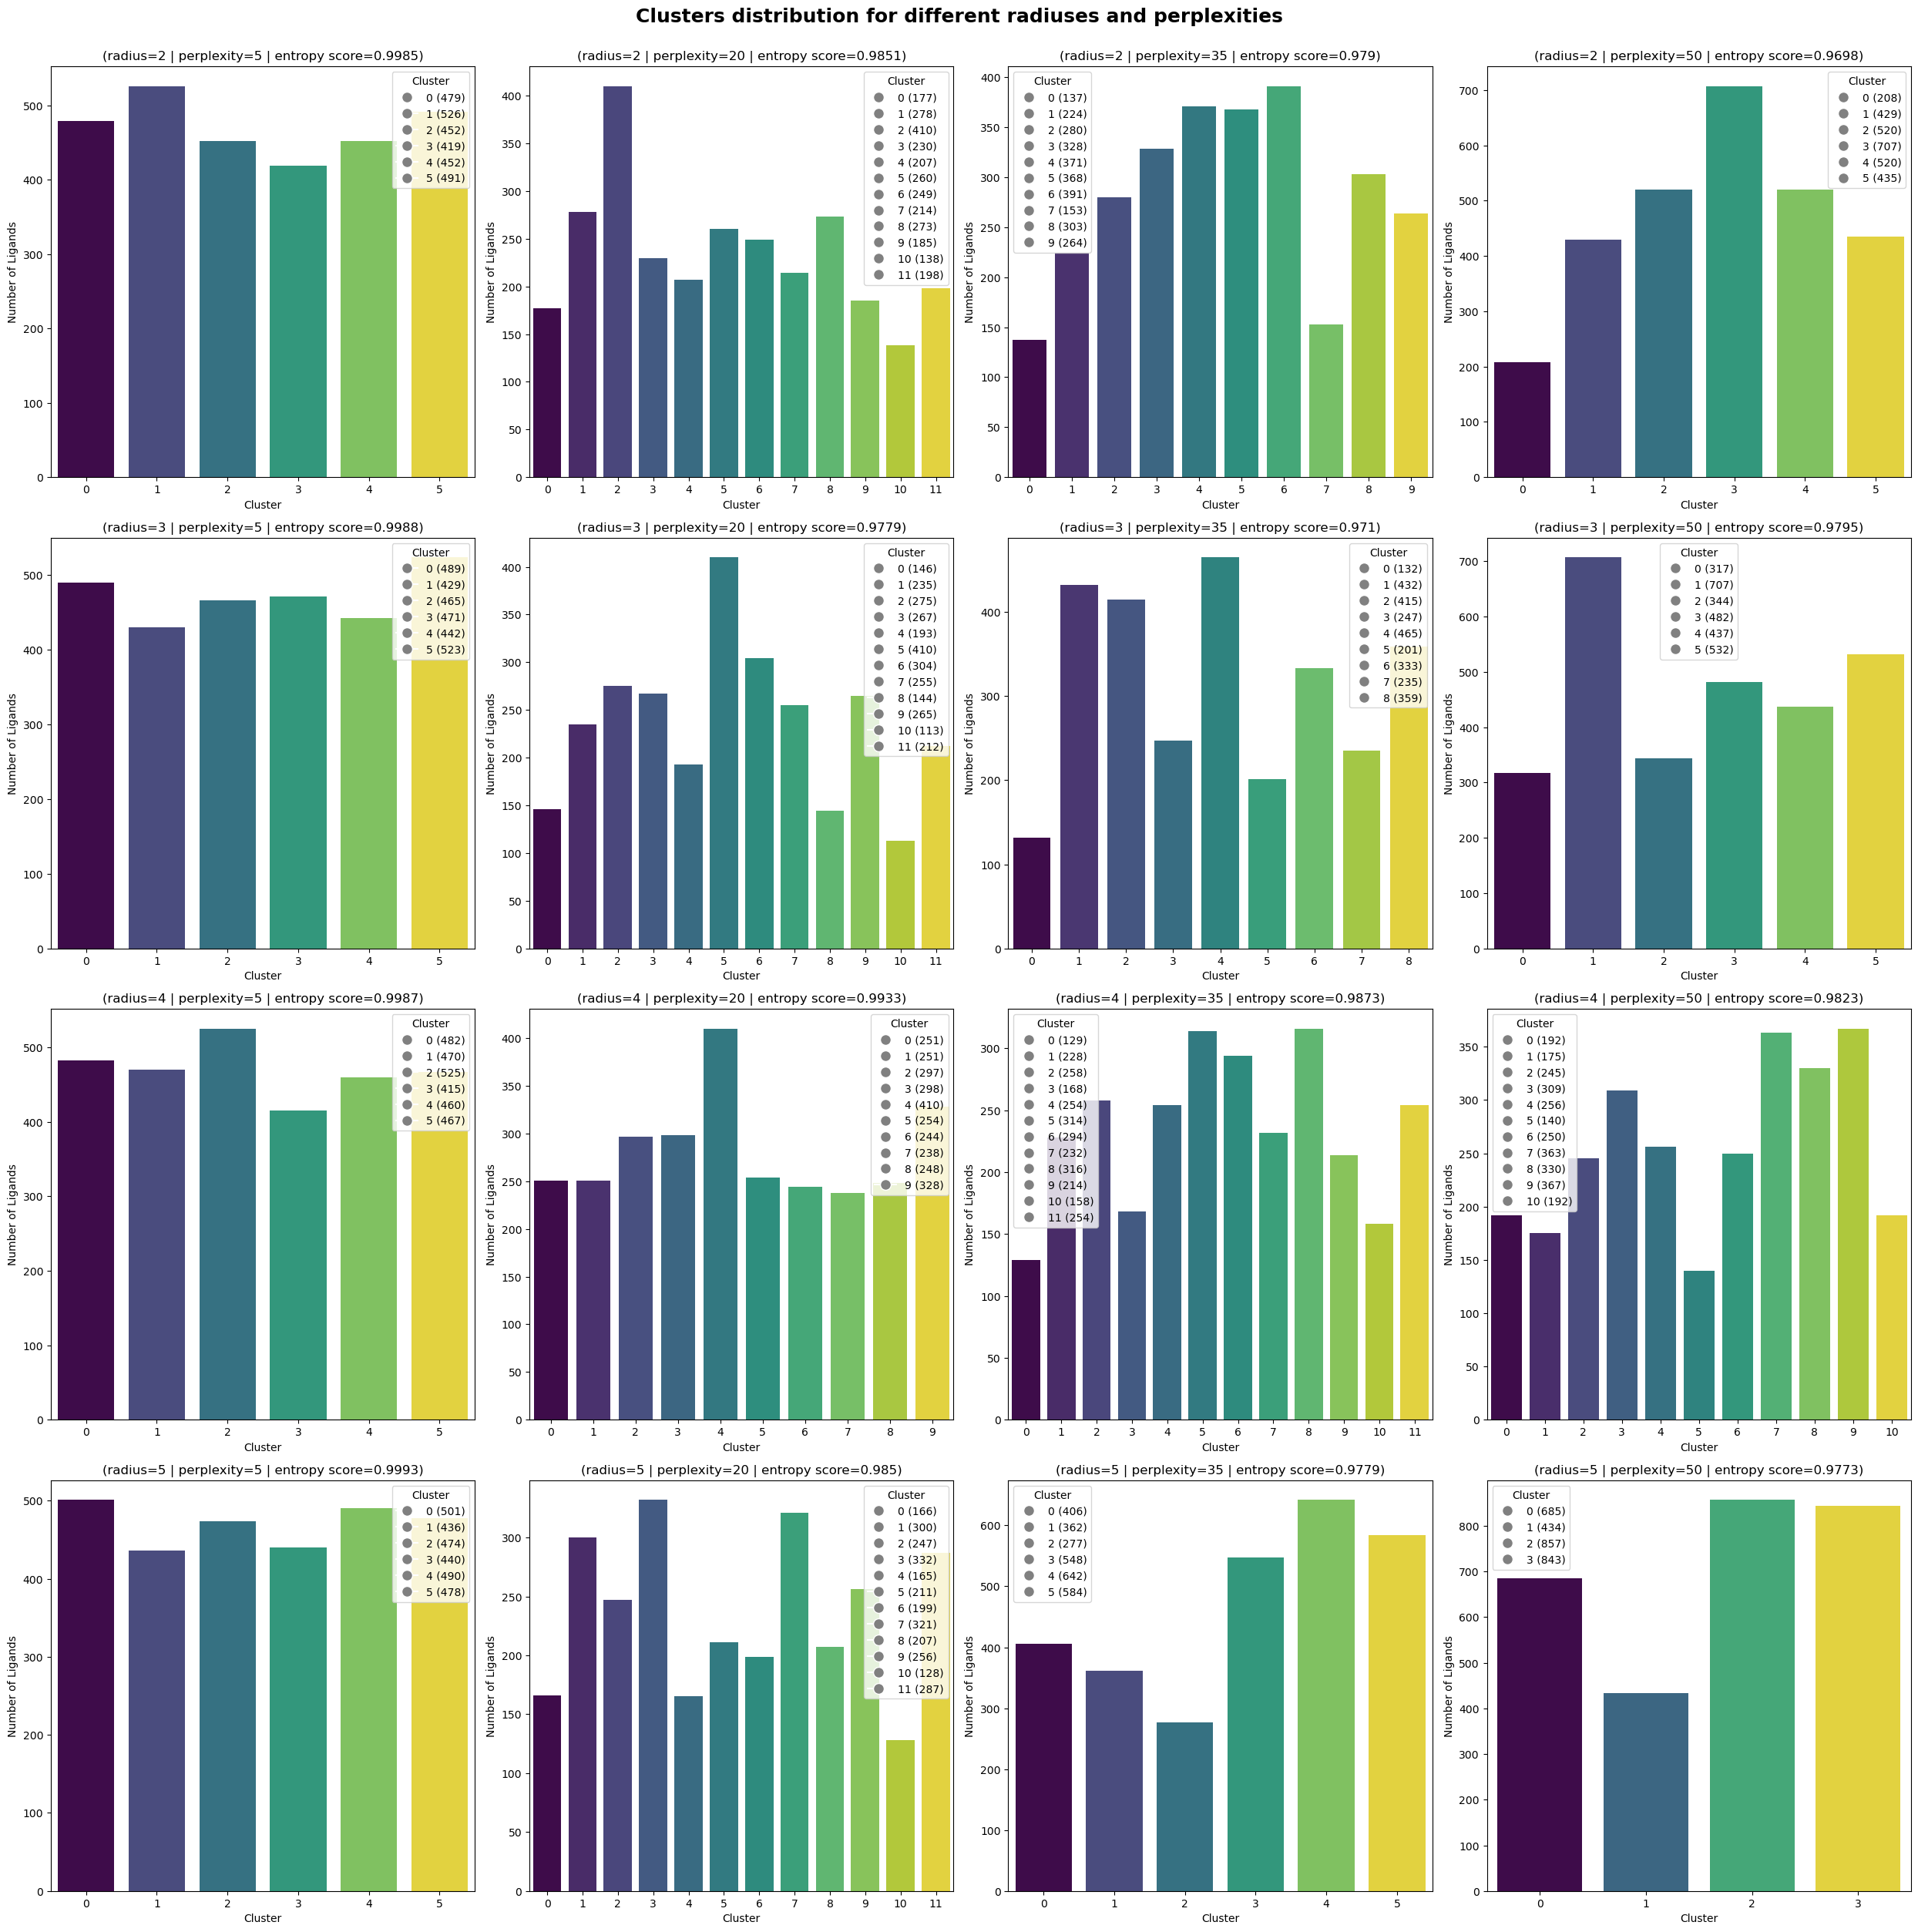

In [22]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities"
)

#### Choose best cluster according to KL metric and check them in reduced spatial representation ####

In [23]:
best_r = 0
best_p = 0
best_kl = 100.0
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'radius: {radiuses[idx_r]} | perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')
        if KLs[idx_r][idx_p] < best_kl:
            min_index = (idx_r,idx_p)
            best_kl = KLs[idx_r][idx_p]
            best_r = radiuses[idx_r]
            best_p = perplexities[idx_p]

radius: 2 | perplexity: 5 | KL score: 0.552417516708374
radius: 2 | perplexity: 20 | KL score: 0.47736045718193054
radius: 2 | perplexity: 35 | KL score: 0.45127904415130615
radius: 2 | perplexity: 50 | KL score: 0.45064041018486023
radius: 3 | perplexity: 5 | KL score: 0.5536050200462341
radius: 3 | perplexity: 20 | KL score: 0.47465646266937256
radius: 3 | perplexity: 35 | KL score: 0.4576427936553955
radius: 3 | perplexity: 50 | KL score: 0.45243561267852783
radius: 4 | perplexity: 5 | KL score: 0.5375213623046875
radius: 4 | perplexity: 20 | KL score: 0.46273958683013916
radius: 4 | perplexity: 35 | KL score: 0.46268394589424133
radius: 4 | perplexity: 50 | KL score: 0.46262767910957336
radius: 5 | perplexity: 5 | KL score: 0.5201210975646973
radius: 5 | perplexity: 20 | KL score: 0.4685295820236206
radius: 5 | perplexity: 35 | KL score: 0.46512728929519653
radius: 5 | perplexity: 50 | KL score: 0.47749006748199463


In [24]:
MANUAL_INDEX = False

if MANUAL_INDEX:
    min_index = (0,3)
    best_kl = KLs[min_index[0]][min_index[1]]
    best_r = radiuses[min_index[0]]
    best_p = perplexities[min_index[1]]

k = best_ks[min_index[0]][min_index[1]]

In [25]:
print(f'Our best hyperparameters is: Radius of {best_r}, Perplexity of {best_p} with KL Divergence of {best_kl}')

Our best hyperparameters is: Radius of 2, Perplexity of 50 with KL Divergence of 0.45064041018486023


In [26]:
TSNE_MF_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of Morgan Fingerprint clustering using t-SNE dimension reduction](test/TSNE_MF.png)

### Using UMAP: Generate Fingerprints + Compute and Plot Scores ###

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


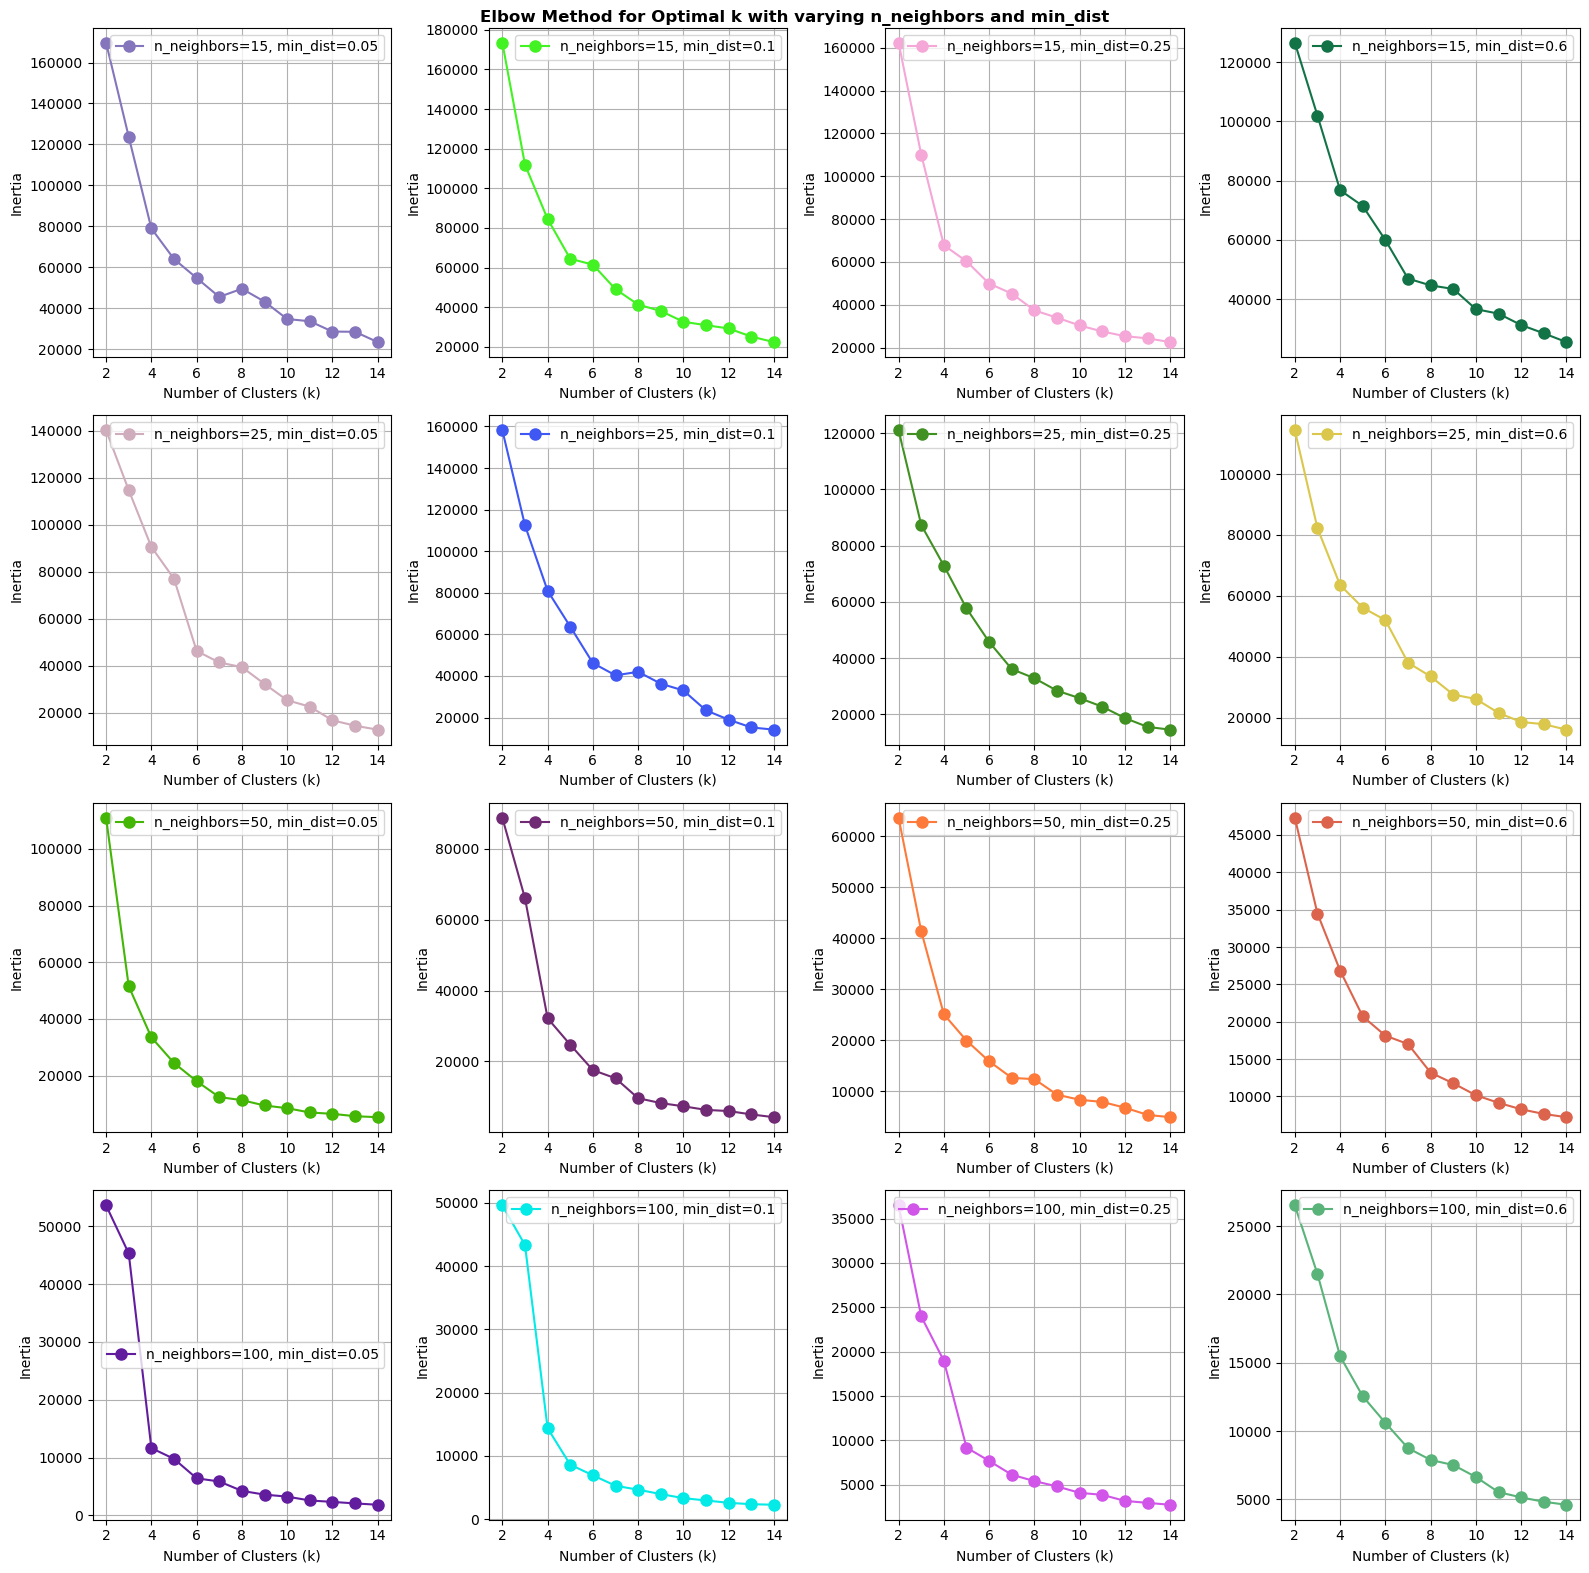

In [77]:
# Important parameters for UMAP are the minimum number of neighbors and the minimum distance between neighbors.
# We don't tune the radius for Morgan Fingerprints as this would clutter the analysis. Instead we take the one that performed best
# in t-SNE (default is put to 3 in the implementations)

l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
    method='umap',
    original_data=smiles_list,
    param1_list=l_n_neighbors,
    param2_list=min_dists,
    Ks=Ks,
    param1_name='n_neighbors',
    param2_name='min_dist',
    metric='jaccard',
    generate_MF=True
)

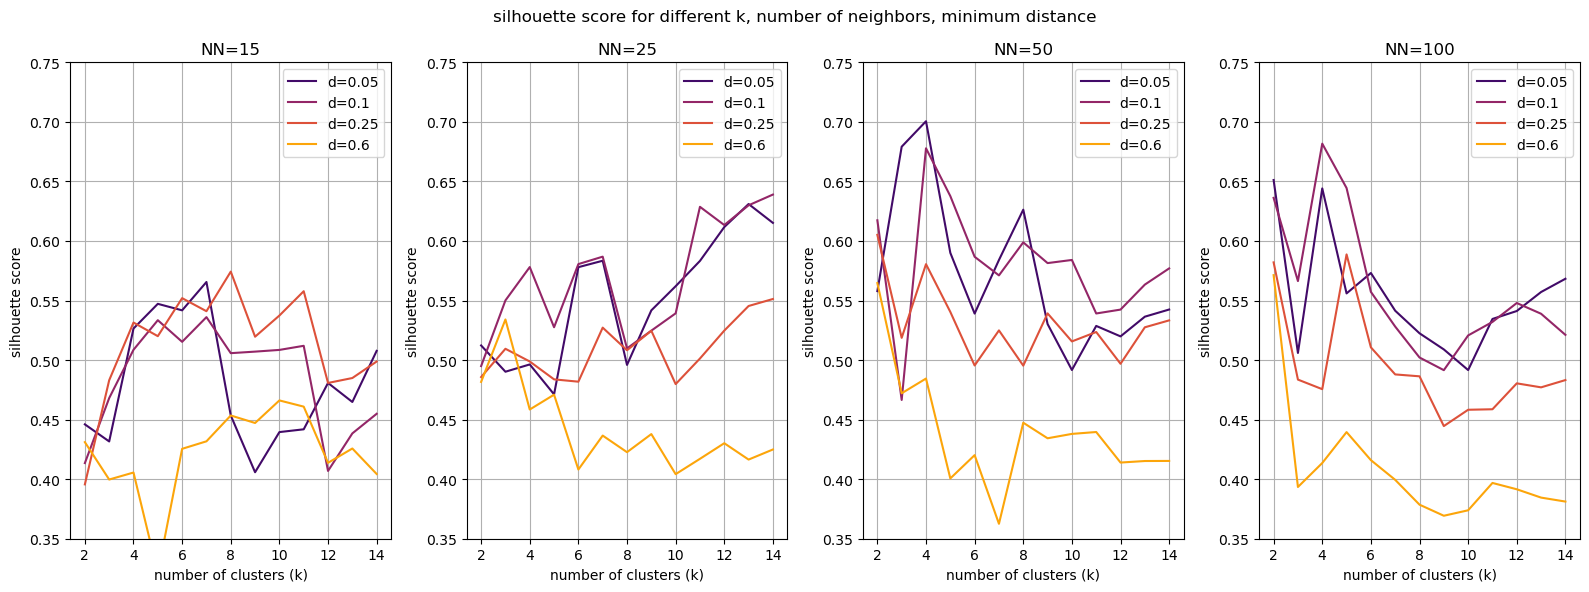

In [78]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.35, 0.75),
    color_palette="inferno", title="silhouette score for different k, number of neighbors, minimum distance"
)

In [79]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[7,6,5,11],
           [12,3,5,4],
           [4,4,4,2],
           [4,4,4,2]]

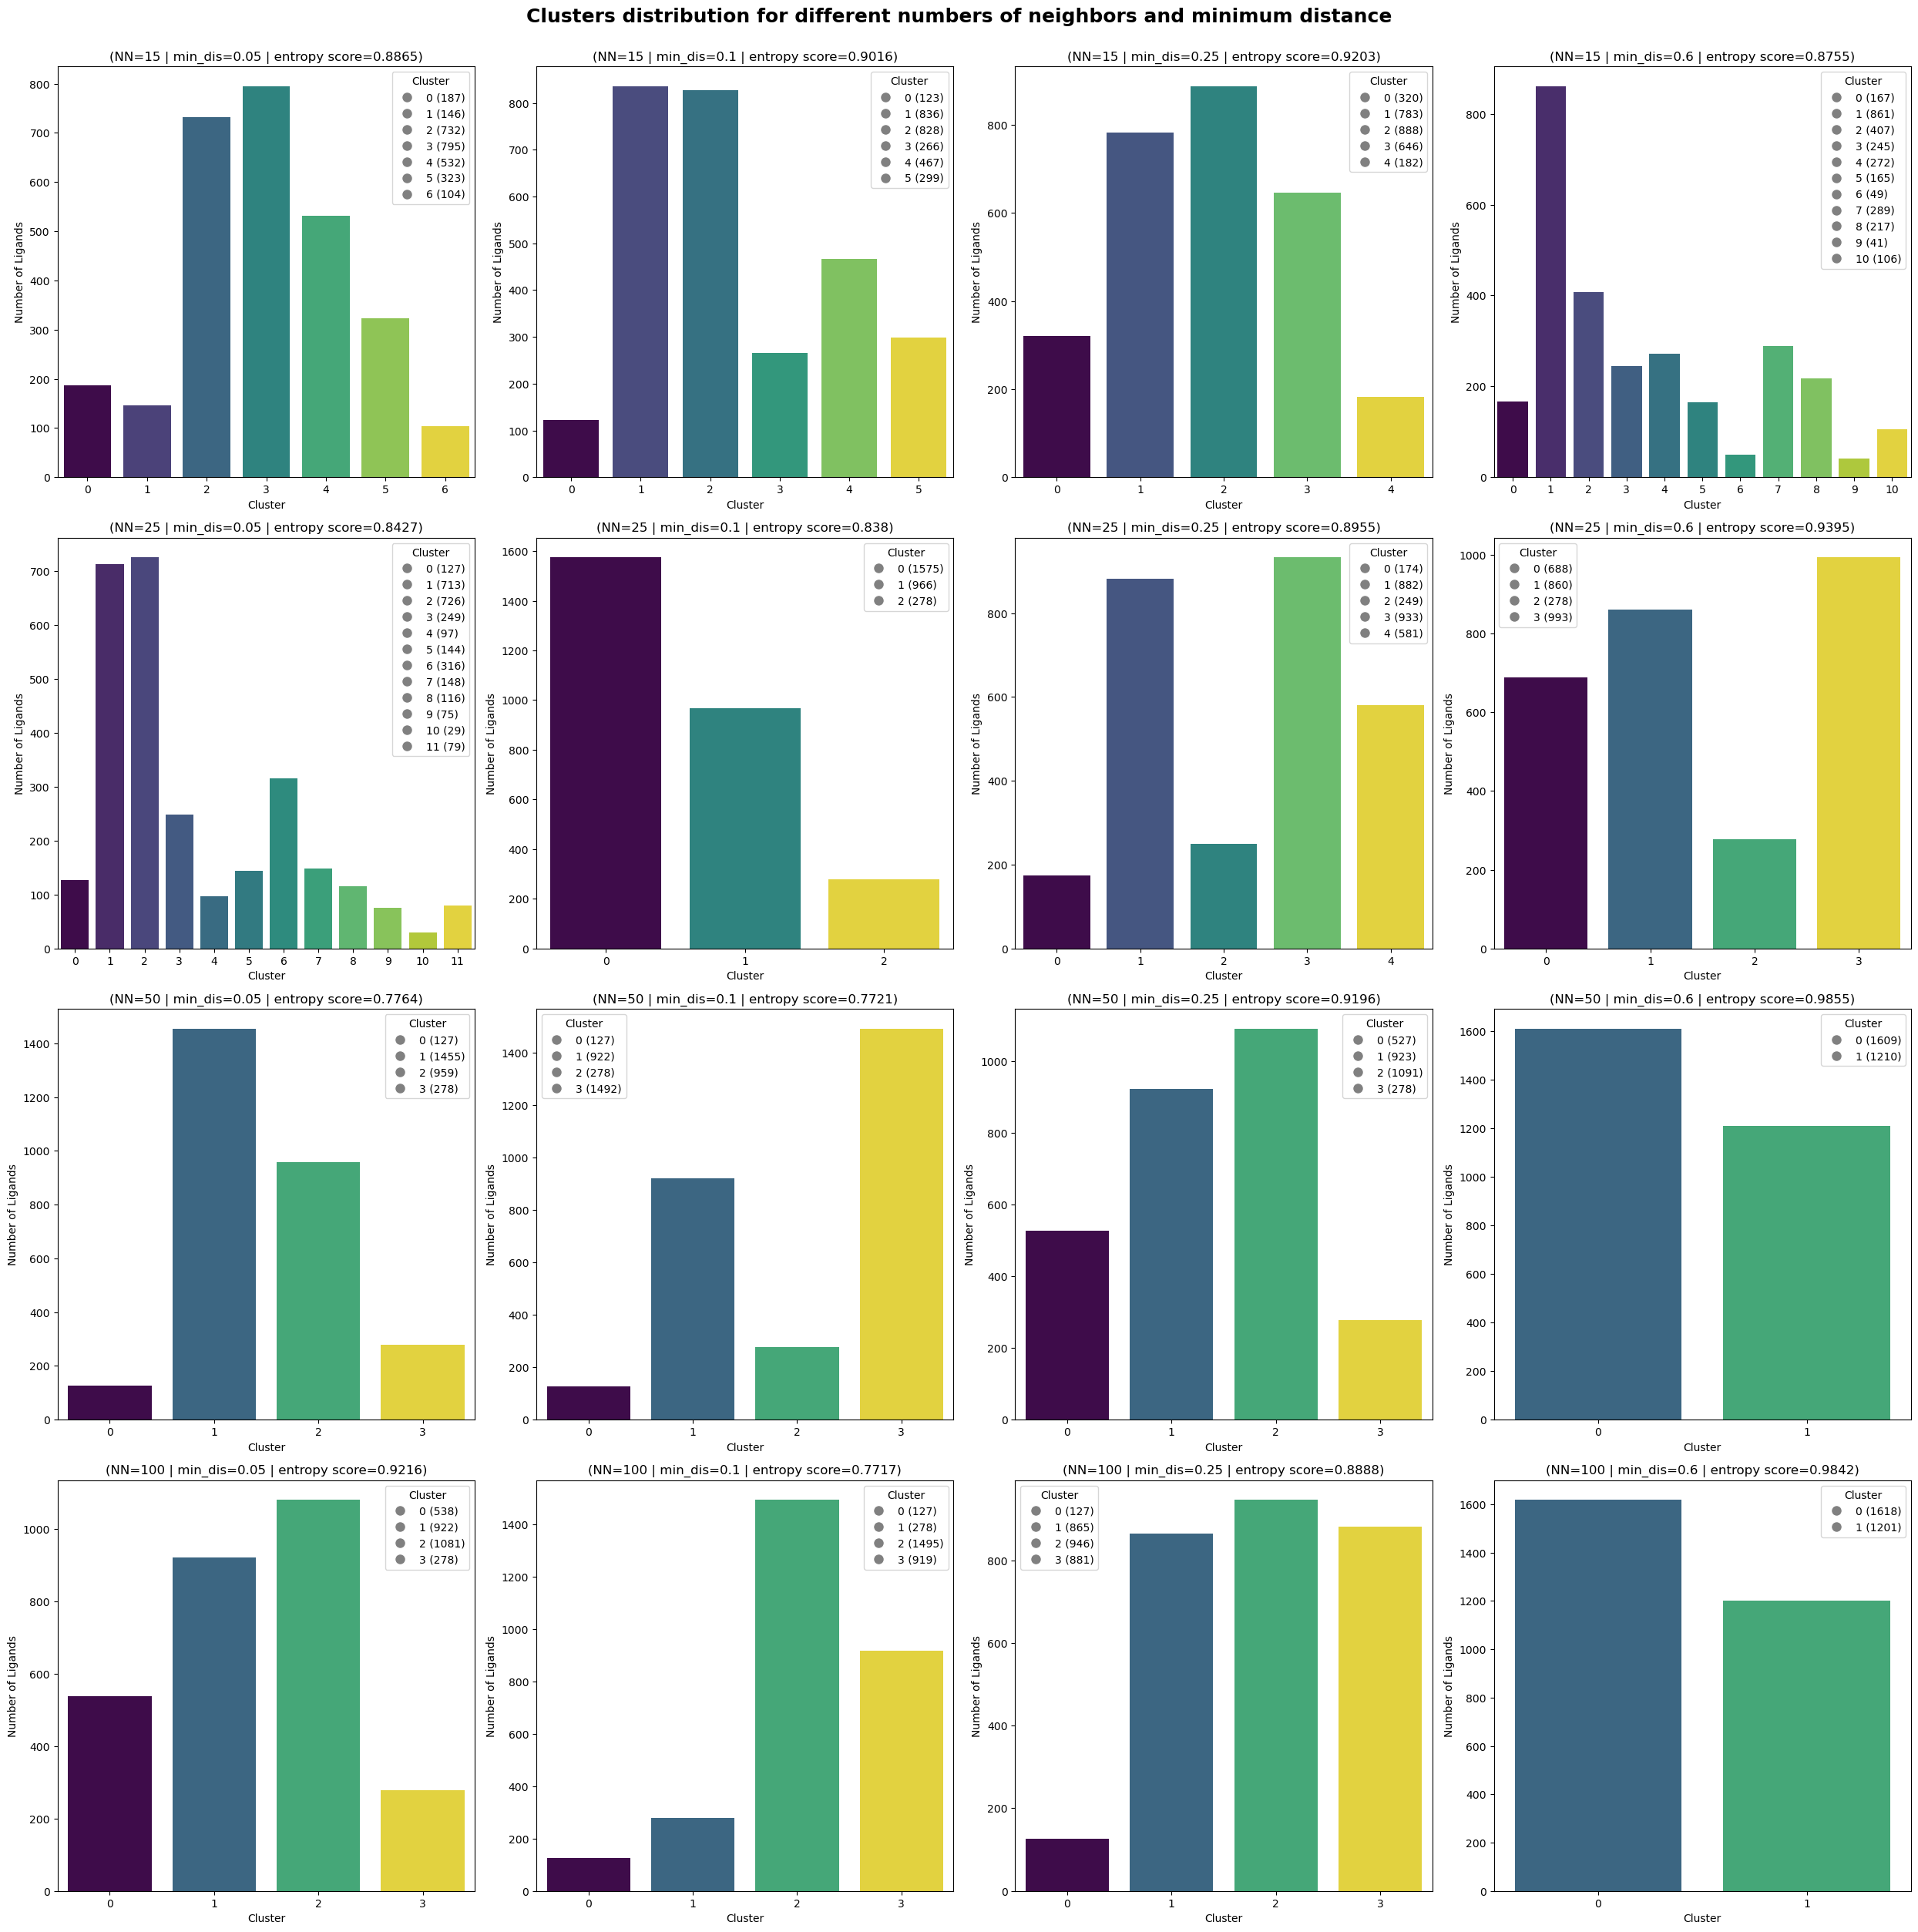

In [80]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_dis',
    title="Clusters distribution for different numbers of neighbors and minimum distance"
)

In [81]:
best_NN = 0
best_d = 0
best_trust = 0
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'number of neighbors: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trust score: {trust_scores[idx_n][idx_d]}')
        if trust_scores[idx_n][idx_d] > best_trust:
            min_index = (idx_n,idx_d)
            best_kl = trust_scores[idx_n][idx_d]
            best_NN = l_n_neighbors[idx_n]
            best_d = min_dists[idx_d]

number of neighbors: 15 | minimum distance: 0.05 | trust score: 0.9603722390624421
number of neighbors: 15 | minimum distance: 0.1 | trust score: 0.9628599649865524
number of neighbors: 15 | minimum distance: 0.25 | trust score: 0.9636095958296477
number of neighbors: 15 | minimum distance: 0.6 | trust score: 0.9646963271065965
number of neighbors: 25 | minimum distance: 0.05 | trust score: 0.9402120633360797
number of neighbors: 25 | minimum distance: 0.1 | trust score: 0.9425217921386431
number of neighbors: 25 | minimum distance: 0.25 | trust score: 0.9428416078852611
number of neighbors: 25 | minimum distance: 0.6 | trust score: 0.9423703310828471
number of neighbors: 50 | minimum distance: 0.05 | trust score: 0.8983019918795453
number of neighbors: 50 | minimum distance: 0.1 | trust score: 0.8992155718056022
number of neighbors: 50 | minimum distance: 0.25 | trust score: 0.8984413829120306
number of neighbors: 50 | minimum distance: 0.6 | trust score: 0.9037229097018183
number of 

In [82]:
# use trustworthiness or choose manually 
MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (3,1)
    best_NN = l_n_neighbors[min_index[0]]
    best_d = min_dists[min_index[1]]
    best_trust = trust_scores[min_index[0]][min_index[1]]
    
k = best_ks[min_index[0]][min_index[1]]

In [83]:
print(f'Our best hyperparameters is: Number of Neighbors of {best_NN}, Minimum Distance of {best_d} with Trust Score of {best_trust}')

Our best hyperparameters is: Number of Neighbors of 100, Minimum Distance of 0.1 with Trust Score of 0.8427609937997353


In [84]:
UMAP_MF_df = plot_3d_clusters(umap_results, min_index, k, method_name='UMAP')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of Morgan Fingerprint clustering using UMAP dimension reduction](test/UMAP_MF.png)

In [85]:
embeddings = generate_fingerprints(smiles_list, radius=2)
model = umap.UMAP(n_components=3, n_neighbors=100, min_dist=0.1, metric='jaccard')
result = model.fit_transform(embeddings)


method_name = 'UMAP'
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(result)

unique_smiles= pd.DataFrame()
unique_smiles['Ligand SMILES']=smiles_list
unique_smiles['Cluster']=kmeans.labels_
unique_smiles.head()

Ligand SMILES  Cluster
0  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...        1
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...        1
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...        1
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...        1
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...        1

In [ ]:
unique_smiles.shape


(2819, 2)

In [86]:
hiv_data_uniqueSmiles=hiv_data.copy()
hiv_data_uniqueSmiles.sample(10)

Ligand SMILES  \
1145   CCC(Cc1ccccc1)c1cc(O)c(C(C2CC2)c2cccc(NS(=O)(=...   
8494   O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(Cc2cccc(c2...   
16143         CC(c1nc([nH]c(=O)c1C)N1CCOCC1)c1c(F)cccc1F   
20434  COc1ccc(cc1)S(=O)(=O)N(CC(C)C)C[C@@H](O)[C@H](...   
1716   O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(Cc2cccc(c2...   
3618   CNC(=O)OCCCC(C)(C)CN(C[C@@H](O)[C@H](Cc1ccccc1...   
66     CNC(=O)OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H]...   
21696  COc1ccc(cc1)S(=O)(=O)N(CC(C)C)C[C@@H](O)[C@H](...   
6790   Oc1c2CCCCCCc2oc(=O)c1C(C1CC1)c1cccc(NC(=O)c2cc...   
8377   O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(Cc2cccc(c2...   

                                        Target Name  \
1145         Dimer of Gag-Pol polyprotein [489-587]   
8494                  Gag-Pol polyprotein [489-587]   
16143                         Reverse transcriptase   
20434                 Gag-Pol polyprotein [489-587]   
1716         Dimer of Gag-Pol polyprotein [489-587]   
3618   Dimer of Gag-Pol polyprotein [489-587,I539V]   
66           Dimer of Gag-Pol polyprotein [501-599]   
21696                 Gag-Pol polyprotein [489-587]   
6790                  Gag-Pol polyprotein [489-587]   
8377                  Gag-Pol polyprotein [489-587]   

      Target Source Organism According to Curator or DataSource    Ki (nM)  \
1145                      Human immunodeficiency virus 1               5.7   
8494                      Human immunodeficiency virus 1             0.024   
16143                     Human immunodeficiency virus 1               500   
20434                     Human immunodeficiency virus 1          0.280000   
1716                      Human immunodeficiency virus 1                27   
3618                      Human immunodeficiency virus 1             0.027   
66                        Human immunodeficiency virus 1                46   
21696                     Human immunodeficiency virus 1          0.110000   
6790                      Human immunodeficiency virus 1                55   
8377                      Human immunodeficiency virus 1             0.014   

      IC50 (nM) Kd (nM) EC50 (nM) kon (M-1-s-1) koff (s-1)   pH  ...  \
1145        NaN     NaN       NaN           NaN        NaN  5.0  ...   
8494        NaN     NaN       NaN           NaN        NaN  NaN  ...   
16143       NaN     NaN       NaN           NaN        NaN  NaN  ...   
20434       NaN     NaN       NaN           NaN        NaN  NaN  ...   
1716        NaN     NaN       NaN           NaN        NaN  5.5  ...   
3618        NaN     NaN       NaN           NaN        NaN  5.5  ...   
66          NaN     NaN       NaN           NaN        NaN  5.5  ...   
21696       NaN     NaN       NaN           NaN        NaN  NaN  ...   
6790        NaN     NaN       NaN           NaN        NaN  NaN  ...   
8377        NaN     NaN       NaN           NaN        NaN  NaN  ...   

      BindingDB Target Chain Sequence.3 BindingDB Target Chain Sequence.4  \
1145                                NaN                               NaN   
8494                                NaN                               NaN   
16143                               NaN                               NaN   
20434                               NaN                               NaN   
1716                                NaN                               NaN   
3618                                NaN                               NaN   
66                                  NaN                               NaN   
21696                               NaN                               NaN   
6790                                NaN                               NaN   
8377                                NaN                               NaN   

       BindingDB Target Chain Sequence.5 BindingDB Target Chain Sequence.6  \
1145                                 NaN                               NaN   
8494                                 NaN                               NaN   
16143                                NaN  

In [87]:
hiv_data_uniqueSmiles=pd.merge(hiv_data_uniqueSmiles, unique_smiles, on='Ligand SMILES', how='inner')
hiv_data_uniqueSmiles.sample(10)


Ligand SMILES  \
4165  CCC(Cc1ccccc1)c1cc(O)c(C(C2CC2)c2cccc(N[C@@H](...   
694   CCCC(c1cccc(NS(=O)(=O)c2ccc(Cl)cc2)c1)c1c(O)c2...   
27    COC(=O)CCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O...   
2559  COC(=O)[C@@H](NC(=O)[C@@H](CC(C)C)NC(=O)[C@@H]...   
1584  CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]...   
750   O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(Cc2ccc(O)c...   
1889  COC(=O)[C@@H](NC(=O)[C@@H](NC(=O)C[C@H](O)[C@H...   
2294  Nc1cccc(CN2[C@H](Cc3ccccc3)[C@H](O)[C@@H](O)[C...   
446   CC(C)[C@H](NC(=O)[C@H](NCc1ccccc1)[C@H](O)[C@H...   
1842  CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](Cc1cc...   

                                            Target Name  \
4165                      Gag-Pol polyprotein [489-587]   
694              Dimer of Gag-Pol polyprotein [489-587]   
27               Dimer of Gag-Pol polyprotein [501-599]   
2559                      Gag-Pol polyprotein [489-587]   
1584  Dimer of Gag-Pol polyprotein [501-599,Q508K,L5...   
750              Dimer of Gag-Pol polyprotein [489-587]   
1889                      Gag-Pol polyprotein [489-587]   
2294                      Gag-Pol polyprotein [489-587]   
446              Dimer of Gag-Pol polyprotein [489-587]   
1842                      Gag-Pol polyprotein [489-587]   

     Target Source Organism According to Curator or DataSource Ki (nM)  \
4165                     Human immunodeficiency virus 1             15   
694                      Human immunodeficiency virus 1            4.0   
27                       Human immunodeficiency virus 1            4.3   
2559                     Human immunodeficiency virus 1            500   
1584                     Human immunodeficiency virus 1          0.016   
750                      Human immunodeficiency virus 1           0.12   
1889                     Human immunodeficiency virus 1          38905   
2294                     Human immunodeficiency virus 1           0.28   
446                      Human immunodeficiency virus 1             51   
1842                     Human immunodeficiency virus 1            0.6   

     IC50 (nM) Kd (nM) EC50 (nM) kon (M-1-s-1) koff (s-1)    pH  ...  \
4165       NaN     NaN       NaN           NaN        NaN   NaN  ...   
694        NaN     NaN       NaN           NaN        NaN   NaN  ...   
27         NaN     NaN       NaN           NaN        NaN  5.50  ...   
2559       NaN     NaN       NaN           NaN        NaN   NaN  ...   
1584       NaN     NaN       1.6           NaN        NaN  6.40  ...   
750        NaN     NaN       NaN           NaN        NaN   NaN  ...   
1889       NaN     NaN       NaN           NaN        NaN   NaN  ...   
2294       NaN     NaN       NaN           NaN        NaN   NaN  ...   
446        NaN     NaN       NaN           NaN        NaN  6.25  ...   
1842       NaN     NaN       NaN           NaN        NaN   NaN  ...   

     BindingDB Target Chain Sequence.4 BindingDB Target Chain Sequence.5  \
4165                               NaN                               NaN   
694                                NaN                               NaN   
27                                 NaN                               NaN   
2559                               NaN                               NaN   
1584                               NaN                               NaN   
750                                NaN                               NaN   
1889                               NaN                               NaN   
2294                               NaN                               NaN   
446                                NaN                               NaN   
1842                               NaN                               NaN   

      BindingDB Target Chain Sequence.6 BindingDB Target Chain Sequence.7  \
4165                                NaN                               NaN   
694                                 NaN                               NaN   
27                                  NaN                           

In [88]:
hiv_data_uniqueSmiles.dropna(subset='Cluster')
hiv_data_uniqueSmiles.shape


(4171, 27)

In [ ]:
hiv_data_uniqueSmiles.to_csv('src/hiv_data_uniqueSMILES_clusters.csv', index=False)
print("Dataset with clusters saved as 'hiv_data_uniqueSMILES_clusters.csv'.")

Dataset with clusters saved as 'hiv_data_uniqueSMILES_clusters.csv'.


## <b>Clustering with BERT Embeddings:</b> ##

Advantages:

- Effectively preserves both local and global structures.
- Suitable for various machine learning models.
- Captures complex relationships and dependencies, with a high number of features, making it highly effective for training complex models, provided overfitting is avoided.

Inconveniences:

- Computationally expensive.
- Difficult to interpret, unlike Morgan Fingerprints.

More info on BERT embedding can be found in the BERT [implementation](https://huggingface.co/seyonec/ChemBERTa-zinc-base-v1), or our implemetations.py file.

Note: for dimension reduction of BERT embeddings, we will use cosine metric as it is suited for semantic relationships

#### Generating embeddings ####

In [30]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"
model, tokenizer = get_BERT_model(model_name)

In [31]:
embeddings = np.zeros((len(smiles_list), 768))

for i in range(len(smiles_list)):
  inputs = tokenizer(smiles_list[i], padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  if i % 500 == 0:
    print(f'iteration {i}')
  embeddings[i] = outputs.last_hidden_state.mean(dim=1).numpy()

iteration 0
iteration 500
iteration 1000
iteration 1500
iteration 2000
iteration 2500


#### Using TSNE to reduce dimensions ####

Radius = 3
Perplexity = 5
Perplexity = 20
Perplexity = 35
Perplexity = 50


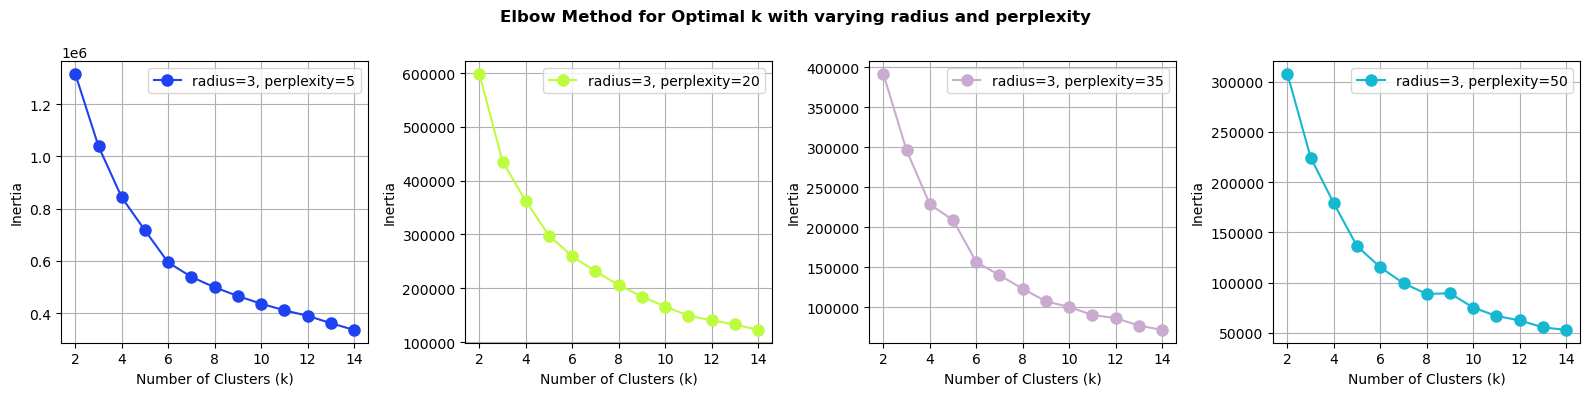

In [32]:
# We don't need radius here as we do not use Morgan Fingerprints, but for the implementation it is necessary to still pass the parameter
radiuses = [3]
perplexities = [5,20,35,50]
Ks = range(2, 15)
nrows, ncols = len(radiuses), len(perplexities)

tsne_results, KLs, s_scores = plot_elbow_curve(
                                                method='tsne',
                                                original_data=embeddings,
                                                param1_list=radiuses,
                                                param2_list=perplexities,
                                                Ks=Ks,
                                                param1_name='radius',
                                                param2_name='perplexity',
                                                metric='cosine'
                                                        )

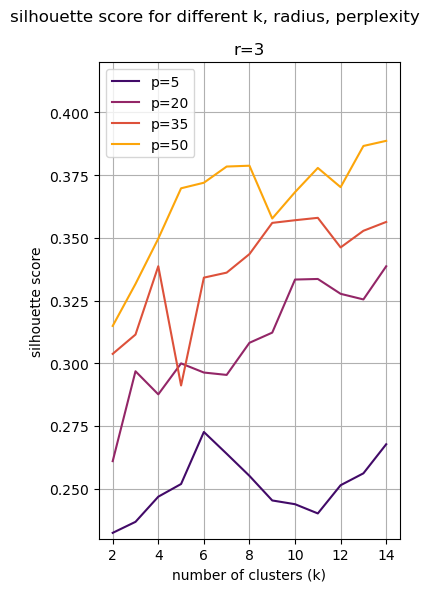

In [33]:
plot_silhouette_scores(
    s_scores, Ks, radiuses, perplexities, 
    param1_name='r', param2_name='p', y_lim=(0.23, 0.42),
    color_palette="inferno", title="silhouette score for different k, radius, perplexity"
)

In [34]:
# Choose best k for each perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,10,11,8]]

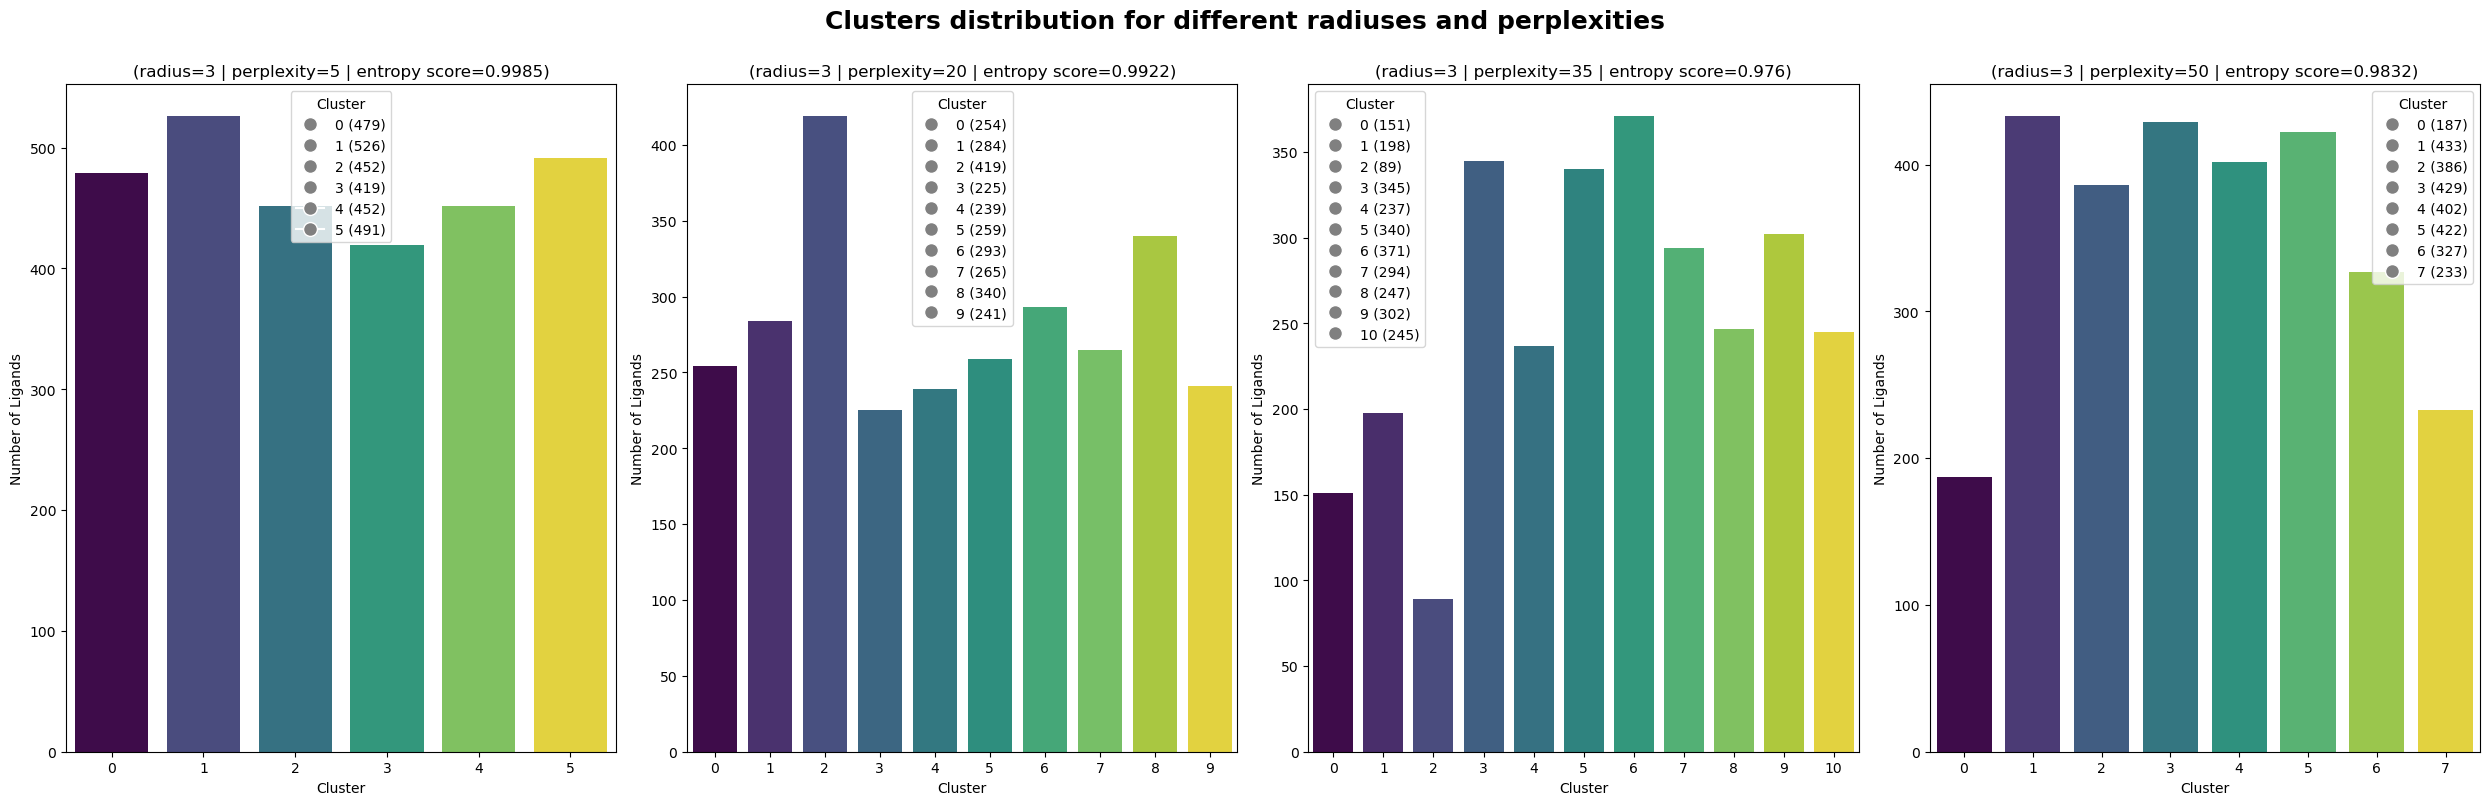

In [35]:
plot_cluster_distributions(
    results=tsn_results, best_ks=best_ks, param1_values=radiuses, param2_values=perplexities,
    param1_name='radius', param2_name='perplexity',
    title="Clusters distribution for different radiuses and perplexities",
    figsize=(25,8)
)

In [36]:
best_p = 0
best_kl = 100.0
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')
        if KLs[idx_r][idx_p] < best_kl:
            min_index = (idx_r,idx_p)
            best_kl = KLs[idx_r][idx_p]
            best_p = perplexities[idx_p]

perplexity: 5 | KL score: 0.499663382768631
perplexity: 20 | KL score: 0.5889309048652649
perplexity: 35 | KL score: 0.613968014717102
perplexity: 50 | KL score: 0.6162129640579224


In [37]:
# use KL or choose manually 

MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (0,3)
    best_kl = KLs[idx_r][idx_p]
    best_p = perplexities[idx_p]

print(min_index)

(0, 3)


In [38]:
print(f'Our best hyperparameters is: Perplexity of {best_p} with KL Divergence of {best_kl}')

Our best hyperparameters is: Perplexity of 50 with KL Divergence of 0.6162129640579224


In [39]:
TSNE_BERT_df = plot_3d_clusters(tsn_results, min_index, k, method_name='TSNE')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of BERT embedding clustering using t-SNE dimension reduction](test/TSNE_BERT.png)

#### Using UMAP to reduce dimensions ####

N_neighbors = 15
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 25
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 50
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6
N_neighbors = 100
Min_dist = 0.05
Min_dist = 0.1
Min_dist = 0.25
Min_dist = 0.6


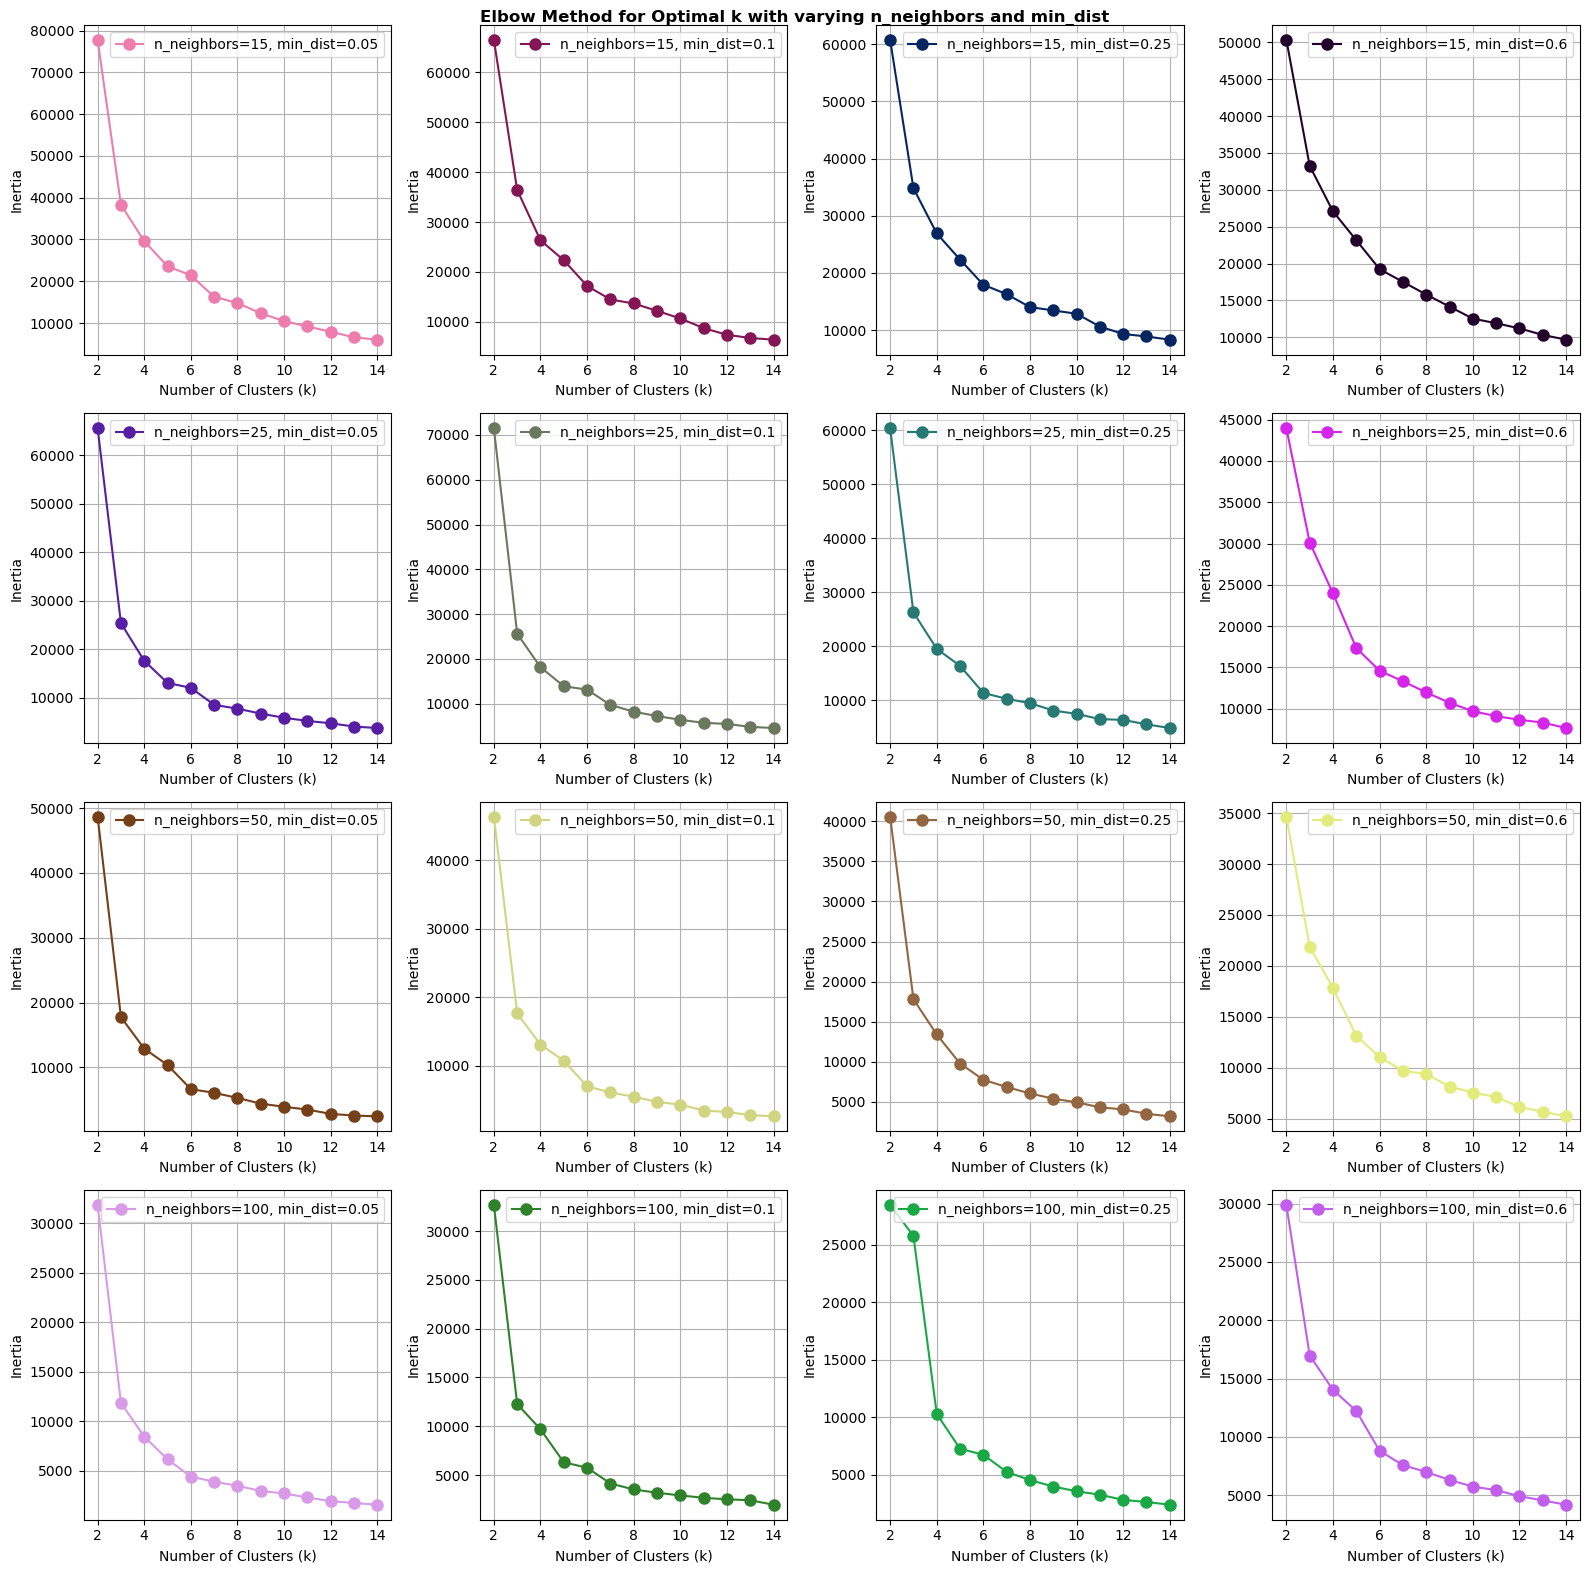

In [40]:
l_n_neighbors = [15,25,50,100]
min_dists = [0.05,0.1,0.25,0.6]
nrows, ncols = len(l_n_neighbors), len(min_dists)
Ks = range(2, 15)

umap_results, trust_scores, s_scores = plot_elbow_curve(
                                        method='umap',
                                        original_data=embeddings,
                                        param1_list=l_n_neighbors,
                                        param2_list=min_dists,
                                        Ks=Ks,
                                        param1_name='n_neighbors',
                                        param2_name='min_dist',
                                        metric='cosine')

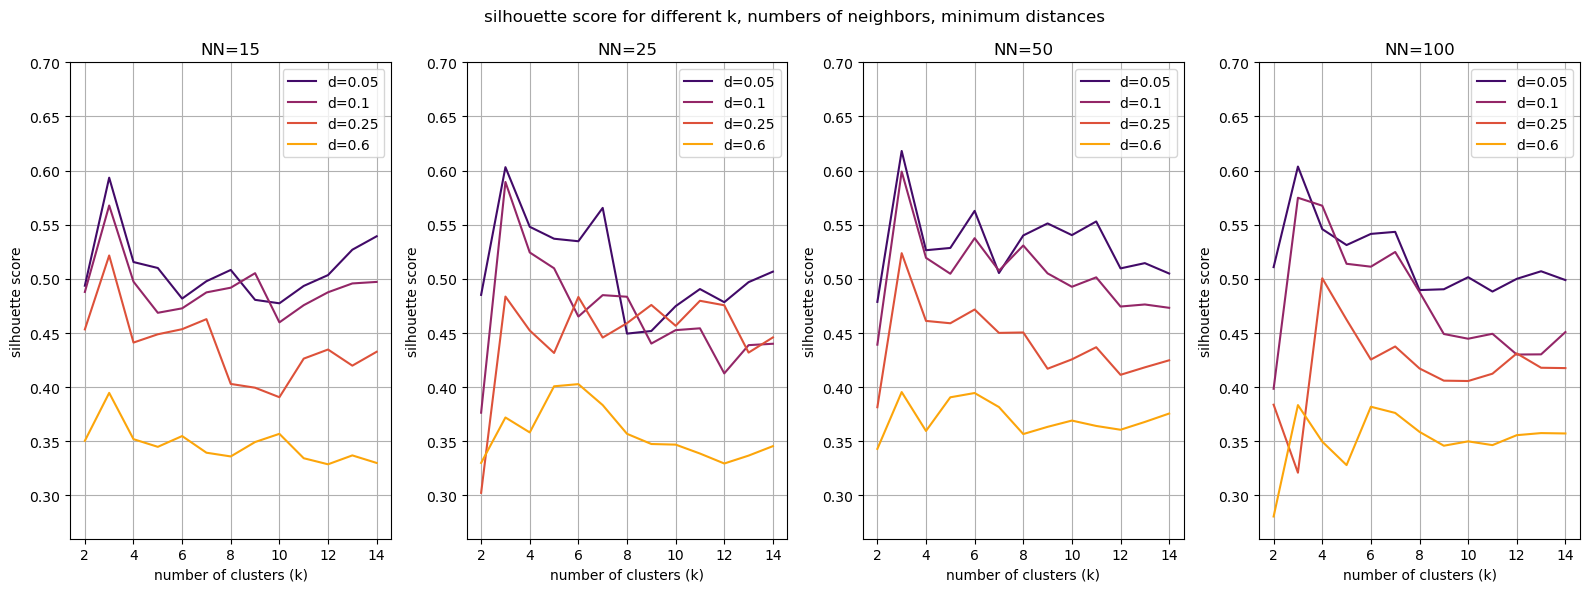

In [41]:
plot_silhouette_scores(
    s_scores, Ks, l_n_neighbors, min_dists, 
    param1_name='NN', param2_name='d', y_lim=(0.26, 0.7),
    color_palette="inferno", title="silhouette score for different k, numbers of neighbors, minimum distances"
)

In [ ]:
# Choose best k for each number of neighbors and minimum distance based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[3,3,3,3],
           [3,3,3,6],
           [3,3,3,3],
           [3,3,4,3]]

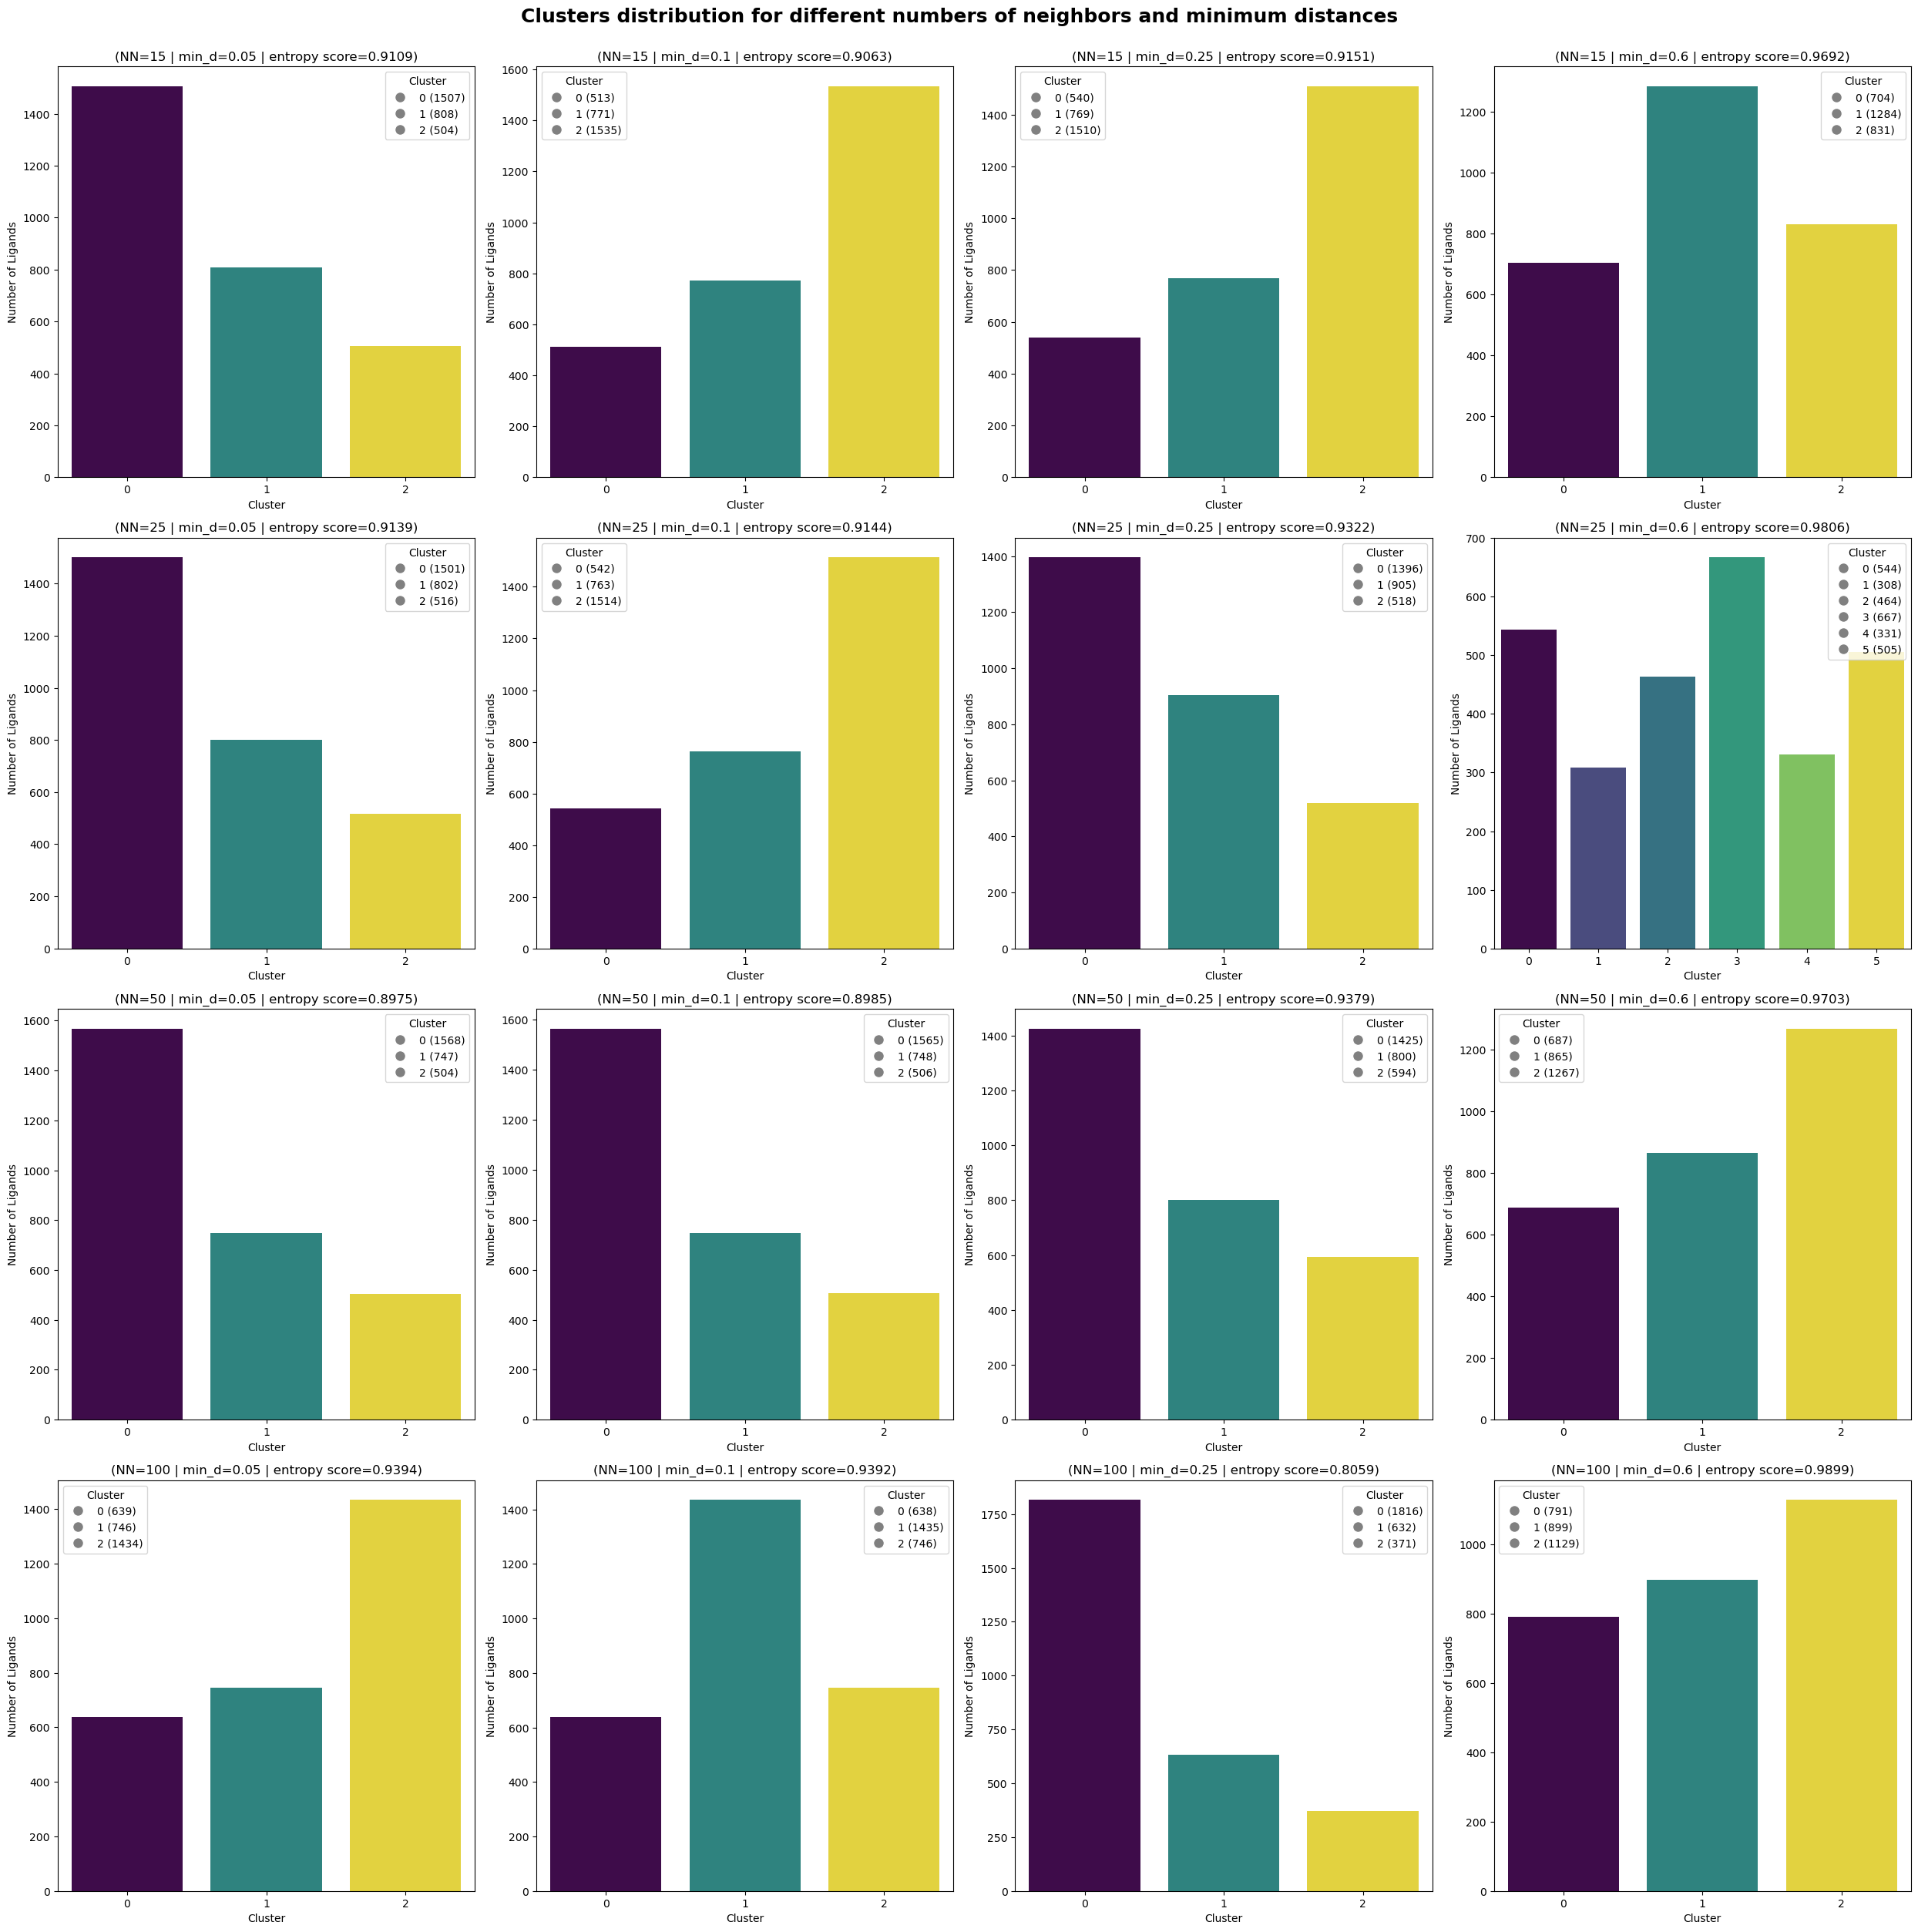

In [43]:
plot_cluster_distributions(
    results=umap_results, best_ks=best_ks, param1_values=l_n_neighbors, param2_values=min_dists,
    param1_name='NN', param2_name='min_d', figsize=(25,25),
    title="Clusters distribution for different numbers of neighbors and minimum distances"
)

In [44]:
best_NN = 0
best_d = 0
best_trust = 0
for idx_n in range(nrows):
    for idx_d in range(ncols):
        print(f'number of neighbors: {l_n_neighbors[idx_n]} | minimum distance: {min_dists[idx_d]} | trust score: {trust_scores[idx_n][idx_d]}')
        if trust_scores[idx_n][idx_d] > best_trust:
            min_index = (idx_n,idx_d)
            best_kl = trust_scores[idx_n][idx_d]
            best_NN = l_n_neighbors[idx_n]
            best_d = min_dists[idx_d]

number of neighbors: 15 | minimum distance: 0.05 | trust score: 0.9829623832962612
number of neighbors: 15 | minimum distance: 0.1 | trust score: 0.9824625730130528
number of neighbors: 15 | minimum distance: 0.25 | trust score: 0.9848113819248532
number of neighbors: 15 | minimum distance: 0.6 | trust score: 0.9831522692513486
number of neighbors: 25 | minimum distance: 0.05 | trust score: 0.9763508753400507
number of neighbors: 25 | minimum distance: 0.1 | trust score: 0.9755066834072335
number of neighbors: 25 | minimum distance: 0.25 | trust score: 0.9758585924683522
number of neighbors: 25 | minimum distance: 0.6 | trust score: 0.9726525366793037
number of neighbors: 50 | minimum distance: 0.05 | trust score: 0.9561405736141919
number of neighbors: 50 | minimum distance: 0.1 | trust score: 0.9569695445127387
number of neighbors: 50 | minimum distance: 0.25 | trust score: 0.9590068330750234
number of neighbors: 50 | minimum distance: 0.6 | trust score: 0.9569041572867288
number of 

In [45]:
# use trustworthiness or choose manually 
MANUAL_INDEX = True

if MANUAL_INDEX:
    min_index = (2,0)
    best_NN = l_n_neighbors[min_index[0]]
    best_d = min_dists[min_index[1]]
    best_trust = trust_scores[min_index[0]][min_index[1]]
    
k = best_ks[min_index[0]][min_index[1]]

In [46]:
print(f'Our best hyperparameters is: Number of Neighbors of {best_NN}, Minimum Distance of {best_d} with Trust Score of {best_trust}')

Our best hyperparameters is: Number of Neighbors of 50, Minimum Distance of 0.05 with Trust Score of 0.9561405736141919


In [47]:
UMAP_BERT_df = plot_3d_clusters(umap_results, (2,0), k, method_name='UMAP')

In the case the 3D interactive plot does not render (if you are not using VSCode), below is a saved image of the plot:

![3D plot of BERT embedding clustering using UMAP dimension reduction](test/UMAP_BERT.png)

# Clusters Analysis
According to the silhouette score and the visual map, we chose to keep the clustering with Morgan fingerprint clustering and dimension reduction by UMAP.

In [ ]:
#import hiv_data_clusters dataset
file_path = 'src/hiv_data_uniqueSMILES_clusters.csv'
hiv_data = pd.read_csv(file_path, sep=',')

hiv_data.shape

(4171, 27)

In [16]:
extract_info_smiles(hiv_data)

We would like to look at the targets in HIV each clusters have 

c:\Users\nithu\ada-2024-project-trendtrackers\src\implementations.py:436: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis', ax = ax)
c:\Users\nithu\ada-2024-project-trendtrackers\src\implementations.py:436: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis', ax = ax)
c:\Users\nithu\ada-2024-project-trendtrackers\src\implementations.py:436: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot

Text(0.5, 0.98, 'Top 20 Targets by Number of Compounds')

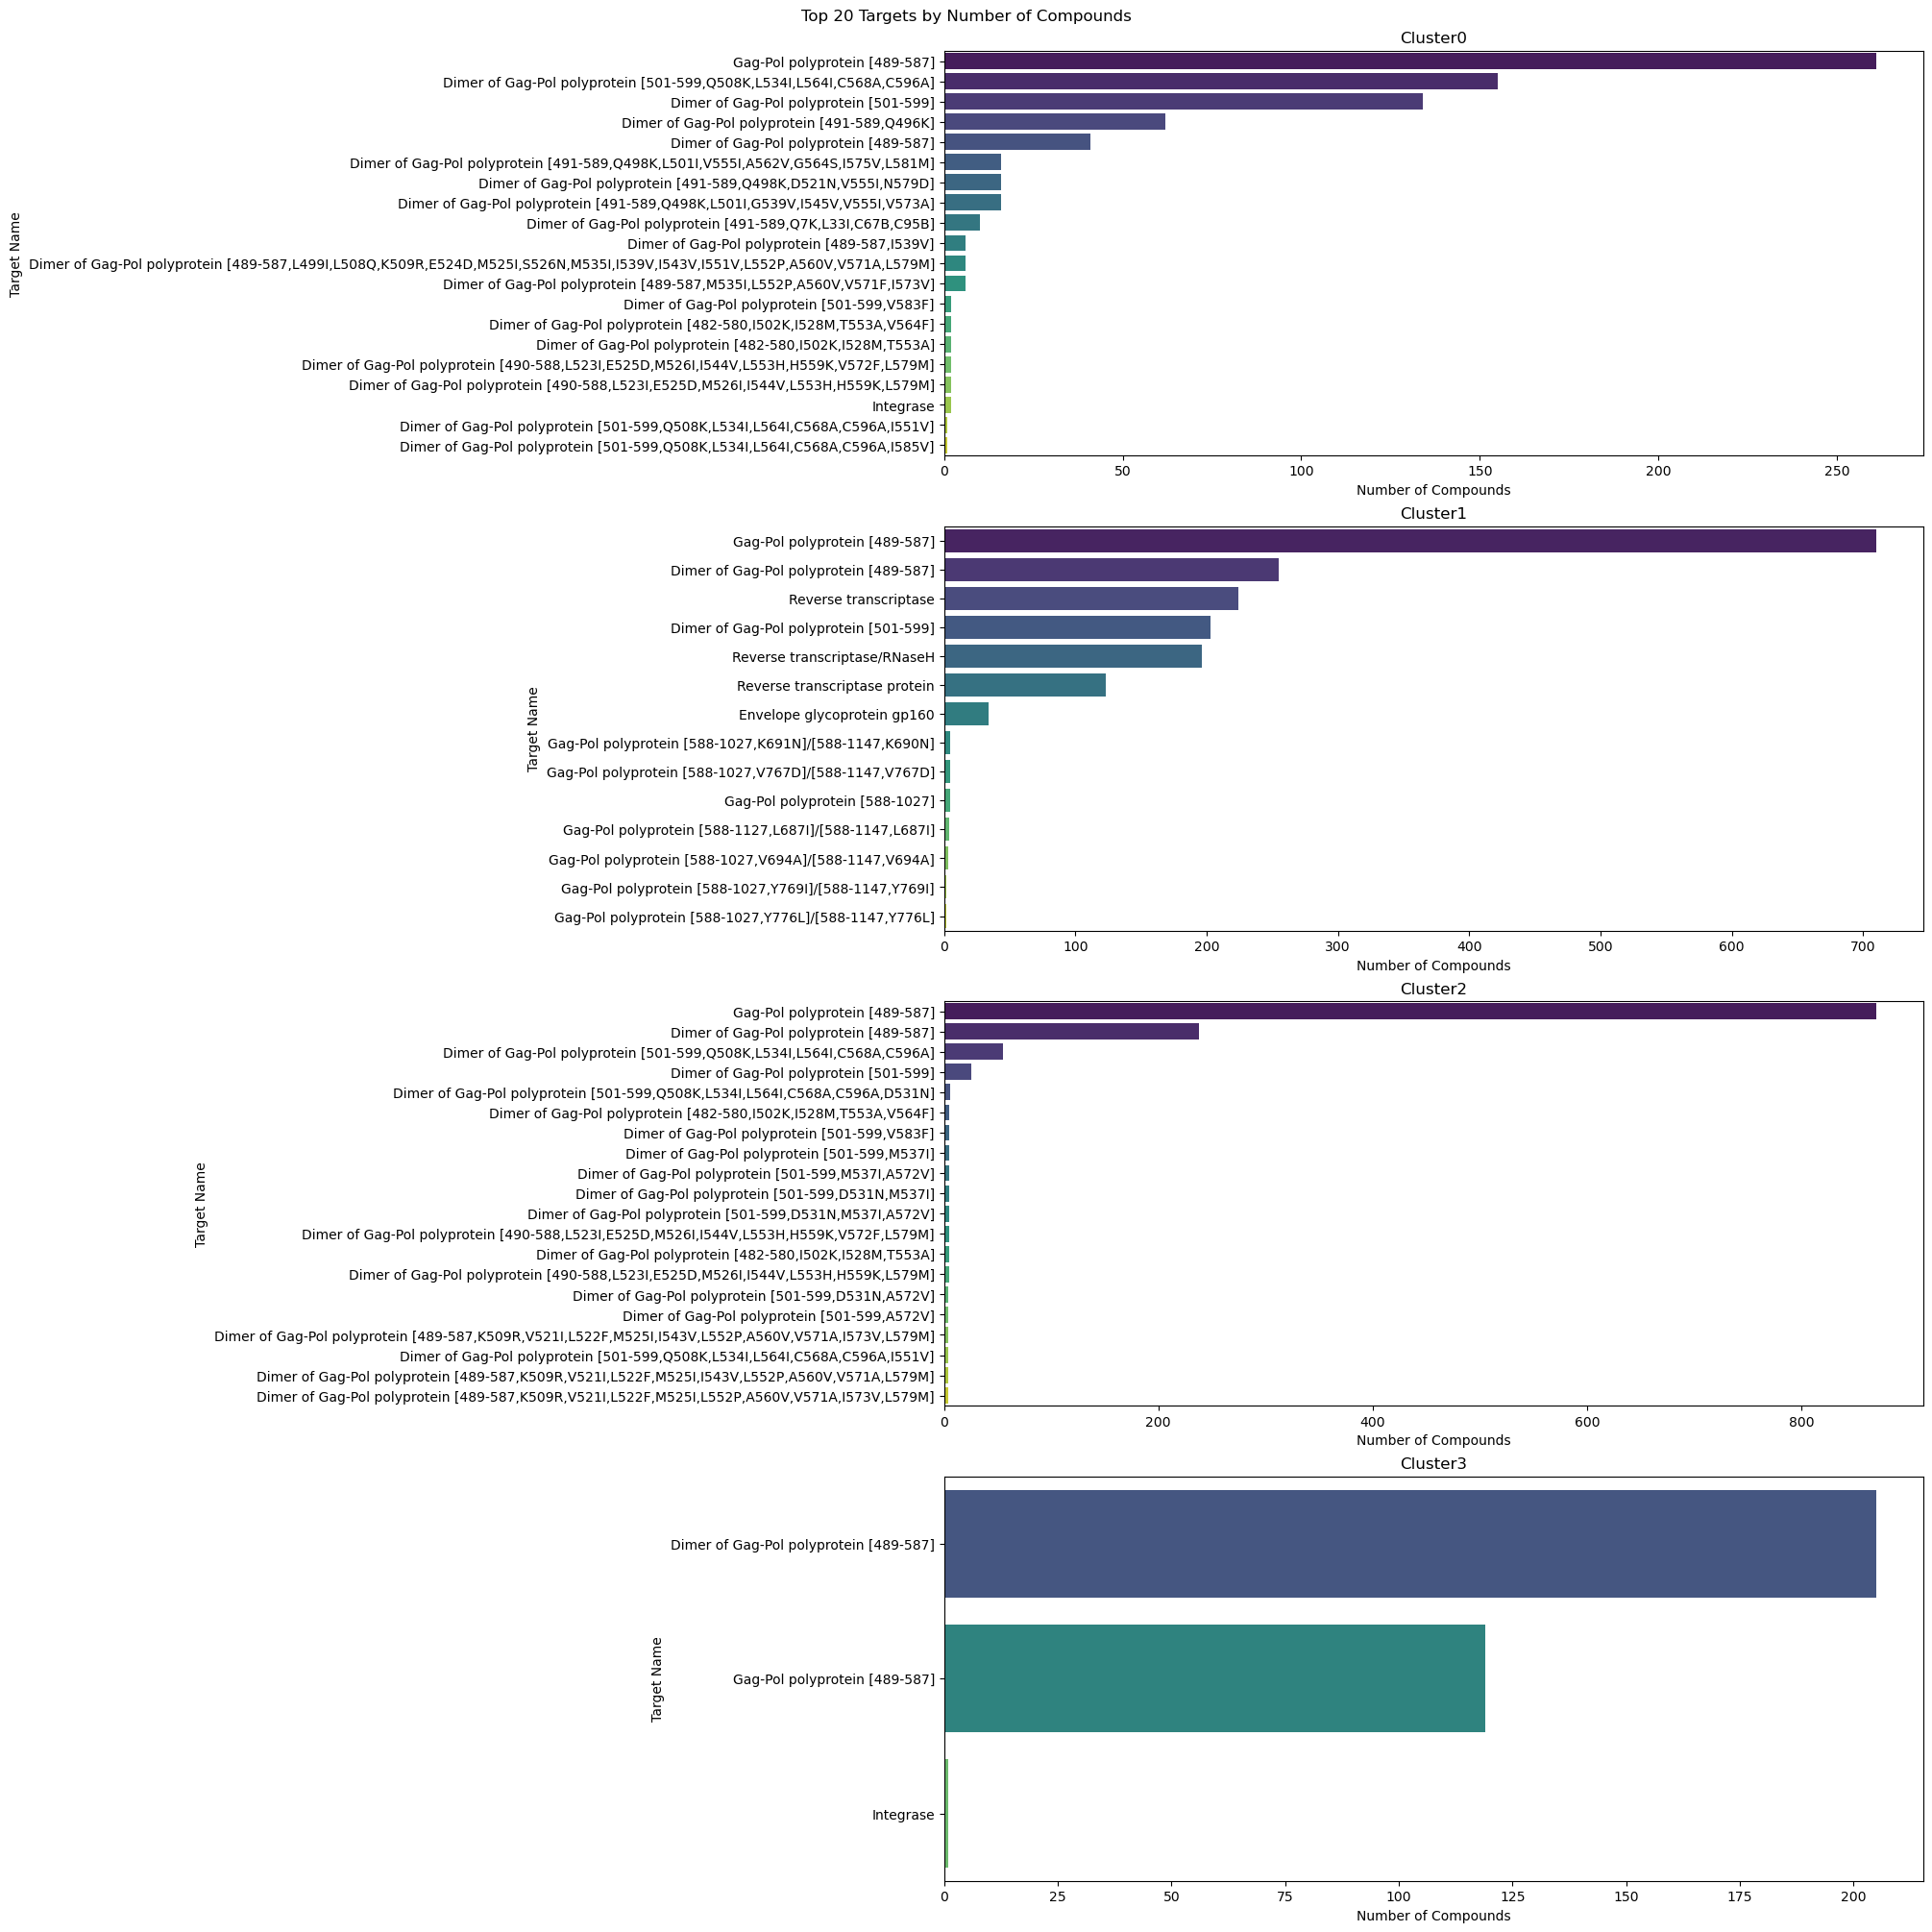

In [17]:
cluster_dataframes={}
for cluster in range(4):
    cluster_dataframes[f'Cluster_{cluster}'] = hiv_data[hiv_data['Cluster'] == cluster]

data_list = [
    {"data": cluster_dataframes['Cluster_0'], "title": "Cluster0", "xlim": (0, 750)},
    {"data": cluster_dataframes['Cluster_1'], "title": "Cluster1", "xlim": (0, 1500)},
    {"data": cluster_dataframes['Cluster_2'], "title": "Cluster2", "xlim": (0, 1500)},
    {"data": cluster_dataframes['Cluster_3'], "title": "Cluster3", "xlim": (0, 1500)}
]

fig, axes = plt.subplots(4, 1, figsize=(20, 20), constrained_layout=True)
# Loop through the data and axes
for ax, data_dict in zip(axes, data_list):
    clusters_targets(data_dict["data"], ax=ax, title = data_dict["title"])

plt.suptitle("Top 20 Targets by Number of Compounds")

The mostly targeted protein in HIV is Gag-pol polyprotein [489-587]. Therefore, we will focus that target.

# Absorption, Distribution, Metabolism, Excretion, and Toxicity (ADMET) properties

In [5]:
from admet_ai import ADMETModel
model = ADMETModel()
preds = model.predict(smiles=hiv_data['Ligand SMILES'])

#for key in preds:
 #   preds[key] = [preds[key]]
df = pd.DataFrame(preds)


c:\Users\nithu\anaconda3\envs\ada\Lib\site-packages\chemprop\utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, l

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.b

c:\Users\nithu\anaconda3\envs\ada\Lib\site-packages\chemprop\utils.py:418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=lambda storage

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.b

model ensembles:   0%|          | 0/2 [00:00<?, ?it/s]









































































































































































































































































































































































































model ensembles:  50%|█████     | 1/2 [01:03<01:03, 63.64s/it]


































































































































































































































































































































































































































model ensembles: 100%|██████████| 2/2 [02:25<00:00, 73.00s/it]


In [9]:
df.to_csv('src/ADMET.csv', index=False)
print("Dataset with clusters saved as 'ADMET.csv'.")

Dataset with clusters saved as 'ADMET.csv'.


In [11]:
data_ADMET= pd.read_csv('src/ADMET.csv')
data_ADMET['Cluster']=hiv_data['Cluster'].copy()


In [18]:
gagpol_df= hiv_data[hiv_data['Target Name']== 'Gag-Pol polyprotein [489-587]']
gagpol_cluster_df={}
for cluster in range(4):
    gagpol_cluster_df[f'Cluster_{cluster}'] = gagpol_df[gagpol_df['Cluster'] == cluster].reset_index(drop=True)
   

data_ADMET['Target Name'] = hiv_data['Target Name']
data_ADMET['Ki']= hiv_data['Ki (nM)']
gagpol_ADMET = data_ADMET[data_ADMET['Target Name']== 'Gag-Pol polyprotein [489-587]']

ADMET_clusters_dataframes_gagpol={}
for cluster in range(4):
    ADMET_clusters_dataframes_gagpol[f'Cluster_{cluster}'] = gagpol_ADMET[gagpol_ADMET['Cluster'] == cluster].reset_index(drop=True)

First property to be analysed is the molecular weight.

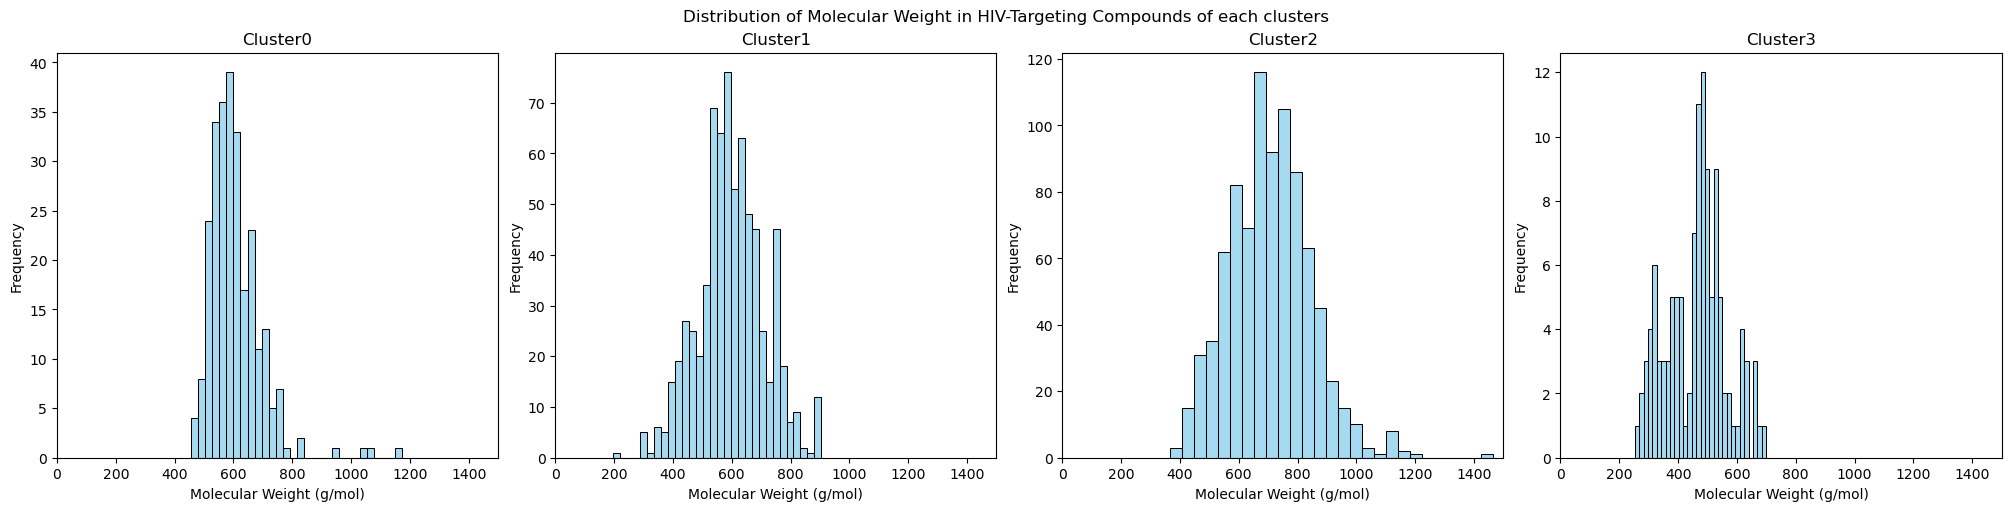

In [19]:
data_list = [
    {"data": gagpol_cluster_df['Cluster_0'], "title": "Cluster0", "xlim": (0, 1500)},
    {"data": gagpol_cluster_df['Cluster_1'], "title": "Cluster1", "xlim": (0, 1500)},
    {"data": gagpol_cluster_df['Cluster_2'], "title": "Cluster2", "xlim": (0, 1500)},
    {"data": gagpol_cluster_df['Cluster_3'], "title": "Cluster3", "xlim": (0, 1500)}
]


fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
# Loop through the data and axes
for ax, data_dict in zip(axes, data_list):
    MW_histplot(data_dict["data"], ax=ax, title= data_dict["title"], xlim=data_dict["xlim"])

# Show the figure
fig.suptitle("Distribution of Molecular Weight in HIV-Targeting Compounds of each clusters")
plt.show()

In [ ]:
#Test wheter the distribution of the molecular weight is normal among the clusters
shapiro_test(ADMET_clusters_dataframes_gagpol, 'Molecular Weight')


In [ ]:

mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['Molecular Weight'], ADMET_clusters_dataframes_gagpol['Cluster_1']['Molecular Weight'], 'cluster 0 and cluster 1.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['Molecular Weight'], ADMET_clusters_dataframes_gagpol['Cluster_2']['Molecular Weight'], 'cluster 0 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['Molecular Weight'], ADMET_clusters_dataframes_gagpol['Cluster_3']['Molecular Weight'], 'cluster 0 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['Molecular Weight'], ADMET_clusters_dataframes_gagpol['Cluster_2']['Molecular Weight'], 'cluster 1 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['Molecular Weight'], ADMET_clusters_dataframes_gagpol['Cluster_3']['Molecular Weight'], 'cluster 1 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_2']['Molecular Weight'], ADMET_clusters_dataframes_gagpol['Cluster_3']['Molecular Weight'], 'cluster 0 and cluster 1.')

Check for the stereo_centers.

In [ ]:
stereo(gagpol_ADMET)

In [ ]:
shapiro_test('stereo_centers')

In [ ]:
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_1']['stereo_centers'], 'cluster 0 and cluster 1.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_2']['stereo_centers'], 'cluster 0 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_0']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_3']['stereo_centers'], 'cluster 0 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_2']['stereo_centers'], 'cluster 1 and cluster 2.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_1']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_3']['stereo_centers'], 'cluster 1 and cluster 3.')
mann_whiteney_test(ADMET_clusters_dataframes_gagpol['Cluster_2']['stereo_centers'], ADMET_clusters_dataframes_gagpol['Cluster_3']['stereo_centers'], 'cluster 0 and cluster 1.')

look for a correlation with Ki

In [ ]:
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
for ax, i in zip(axes, range(4)):
    ax.scatter(ADMET_clusters_dataframes_gagpol[f'Cluster_{i}']['Ki'],ADMET_clusters_dataframes_gagpol[f'Cluster_{i}']['stereo_centers'])
    ax.set_title('Ki vs stereo_percentile')
    ax.set_xlabel('Ki')
    ax.set_ylabel('stereo_centers_drugbank_approved_percentile')
    ax.set_xlim((0, 2))

plt.show()

Look for Hydrophobicity with LogP

In [ ]:
LogP(gagpol_ADMET)

In [ ]:
shapiro_test('stereo_centers')

Since we went through the different properties of the ligands/drugs, we would like to focus on the cluster1 because of the smallest mean value of Ki among the clusters. The smaller the Ki, the greater the binding affinity and the smaller amount of medication needed in order to inhibit the activity of that enzyme. Therefore we would focus on that cluster in order to find the 10 most promising drugs targeting Gag-pol polyprotein.

In [ ]:
top_10_index= Lipinski(ADMET_clusters_dataframes_gagpol).index.tolist()
gagpol_cluster_df['Cluster_1'].iloc[top_10_index]